### Setup

In [554]:
%load_ext autoreload
%autoreload 3 --print
# import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'
# import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

Reloading 'shape_norm.viz.util'.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [555]:
from shape_norm.project.paths import Project, create_model
from shape_norm.io import loaders
from shape_norm.models import joint
from shape_norm import config
from shape_norm.models import instantiation, setup, pose, morph, util as model_util
from shape_norm import fitting
from shape_norm.fitting import em
from shape_norm.io import alignment, features
from shape_norm.io.armature import Armature
from shape_norm.fitting import methods
from shape_norm.fitting import scans
from shape_norm.pca import fit_with_center, CenteredPCA, PCAData
from shape_norm.io.dataset import PytreeDataset
from shape_norm.io.dataset_refactor import Dataset, SessionMetadata
from shape_norm.models.morph.lowrank_affine import LRAParams, model as lra_model
from shape_norm import pca
from blscale_loader import loader, linear_skeletal as blscale_ls
import os, sys, shutil
import numpy as np
from pprint import pprint
from matplotlib import colors as mpl_col
import jax.numpy as jnp
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression, Lasso
import itertools as iit
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import seaborn as sns
from shape_norm import viz
import pandas as pd
from shape_norm.viz import styles
from tensorflow_probability.substrates import jax as tfp
from ruamel.yaml import YAML
from bidict import bidict
import matplotlib.pyplot as plt
from collections import defaultdict
import os, re
import tqdm
from cmap import Colormap
import joblib as jl

from pathlib import Path
import logging
logging.getLogger().setLevel(logging.INFO)

## Supporting funcs

### Datasets

In [15]:
def mouse_data_armature_meta():
    """Organize metadata on keypoints and skeleton of mouse data."""
    names = [
        'shldr', 'back', 'hips', 't_base','t_tip', 'head',
        'l_ear', 'r_ear', 'nose', 'lr_knee', 'lr_foot',
        'rr_knee', 'rr_foot', 'lf_foot', 'rf_foot']
    parents = dict(zip(names, [
        'back', 'hips', None, 'hips', 't_base', 'shldr',
        'head', 'head', 'head', 'hips', 'lr_knee',
        'hips', 'rr_knee', 'shldr', 'shldr']))
    keypt_ix = lambda name: names.index(name)
    bones = np.array([(keypt_ix(c), keypt_ix(p)) for c, p in parents.items() if p])
    root = keypt_ix("shldr")
    bones = blscale_ls.reroot(bones, root)
    bones = bones[np.argsort(bones[:, 0])]
    return names, parents, bones, root


def load_all_mouse_sessions(age_whitelist = None):
    data_root = '../../../data_explore/data'

    # Create mapping of session names (ie 3wk_m0) to keypoint data paths

    modata_npy_name_func = (lambda path, *a:
        match.group(1) if ((match := re.search(r"\d{2}_\d{2}_\d{2}_(\d+wk_m\d+)\.npy", path)) is not None) else None)
    session_paths = dict(filter(lambda x: x[0] is not None, [(modata_npy_name_func(m), str(Path(data_root) / m)) for m in os.listdir(data_root)]))
    # throw out 9-12 week
    session_ages = {s: s.split('_')[0].strip('wk') for s in session_paths}
    ages = set(session_ages.values())
    if age_whitelist is not None:
        ages = list(filter(lambda x: x in age_whitelist, ages))
    session_paths = {s: p for s, p in session_paths.items() if session_ages[s] in ages}
    session_bodies = {s: f'body-{session_ages[s]}wk' for s in session_paths}
    names, parents, _, _ = mouse_data_armature_meta()

    age_dates =  {
        "3" : "10_11_22",
        "5" : "10_24_22",
        "7" : "10_24_22",
        "24": "11_03_22",
        "52" : "11_03_22",
        "72" : "10_14_22",
    }

    print("sessions:", session_paths.keys())

    sesssion_kps = {
        s: np.load(p) for s, p in session_paths.items()
    }

    project_config_kws = {
        "session_names": list(sesssion_kps.keys()),
        "bodies": session_bodies,
        "keypoint_names": names,
        "keypoint_parents": parents,
    }

    return project_config_kws, sesssion_kps

### Plotting

In [37]:
def getc(spec):
    try:
        from cmap import Colormap, Color
        try:
            return Color(spec)
        except ValueError as e:
            stop = spec.split(':')[-1]
            if stop.startswith('.'):
                stop = float(stop)
            else:
                stop = int(stop)
            cm = Colormap(':'.join(spec.split(':')[:-1]))
            return cm(stop)
    except ImportError:
        return spec

def plot_mouse_3d(
    frame,
    ax,
    armature,
    elev,
    rot,
    colors=None,
    bone_n=40,
    point_size=10,
    line_size=2,
    line_colors=None,
    point_kws={},
    line_kws={},
    boundary=True,
    set_aspect=True,
    label = None
):
    """all keys in point kws should be present in line kws"""

    if colors is None:
        import seaborn as sns

        colors = mpl_col.to_rgba(sns.color_palette("Blues", 10 + frame.shape[0])[10:])
    if line_colors is None:
        line_colors = colors
    colors = np.array([mpl_col.to_rgba(x) for x in colors])
    line_colors = np.array([mpl_col.to_rgba(x) for x in line_colors])
    point_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **point_kws,
    }
    line_kws = {
        **dict(
            linewidths=np.array([0] * armature.n_kpts),
        ),
        **line_kws,
    }

    # --- points

    x, y, z, c, s = [], [], [], [], []
    x.append(frame[:, 0])
    y.append(frame[:, 1])
    z.append(frame[:, 2])
    c.append(colors)
    s.append([point_size] * armature.n_kpts)
    kws = {k: [] for k in point_kws}
    concat_keys = []
    for k, v in point_kws.items():
        if np.array(v).shape[:1] == (armature.n_kpts,):
            concat_keys.append(k)
            kws[k].append(v)
        else:
            kws[k] = v

    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])
    point_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    # --- "lines"

    x, y, z, c, s = [], [], [], [], []
    kws = {k: [] for k in line_kws}
    concat_keys = []
    for i, (ch, pa) in enumerate(armature.bones):
        x.append(np.linspace(frame[ch, 0], frame[pa, 0], bone_n)[1:-1])
        y.append(np.linspace(frame[ch, 1], frame[pa, 1], bone_n)[1:-1])
        z.append(np.linspace(frame[ch, 2], frame[pa, 2], bone_n)[1:-1])
        c.append(np.full([bone_n - 2, 4], line_colors[ch]))
        s.append(np.full([bone_n - 2], line_size))
        for k, v in line_kws.items():
            if np.array(v).shape[:1] == (armature.n_kpts,):
                concat_keys.append(k)
                kws[k].append(np.full((bone_n - 2,) + np.array(v).shape[1:], v[ch]))
            else:
                kws[k] = v
    x = np.concatenate(x)
    y = np.concatenate(y)
    z = np.concatenate(z)
    c = np.concatenate(c)
    s = np.concatenate(s)
    for k, v in kws.items():
        if k in concat_keys:
            kws[k] = np.concatenate(kws[k])

    line_artist = ax.scatter(x, y, z, c=c, s=s, depthshade=False, **kws)

    ax.view_init(elev, rot)

    ax.grid(False)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    if not boundary:
        ax.xaxis.pane.set_linewidth(0)
        ax.yaxis.pane.set_linewidth(0)
        ax.zaxis.pane.set_linewidth(0)
        ax.xaxis.line.set_linewidth(0)
        ax.yaxis.line.set_linewidth(0)
        ax.zaxis.line.set_linewidth(0)

    
    # use a.set_box_aspect to make the aspect equal to the ratio of the limits
    if set_aspect:
        xrng = np.ptp(ax.get_xlim())
        yrng = np.ptp(ax.get_ylim())
        zrng = np.ptp(ax.get_zlim())
        ax.set_box_aspect([xrng, yrng, zrng])

    return point_artist, line_artist

### Shape norm utilties

In [42]:
# model manipulation
def lra_anchor_poses(params: LRAParams, magnitudes=90):
    """
    Parameters:
    params (LRAParams):
        Parameters used for calculating anchor poses.
    magnitudes (float, numpy.ndarray):
        The magnitude value used in calculating anchor poses. If a float, the
        same magnitude is used for all anchors. If an array, the magnitude
        for each dimension is specified separately. Not applied to the centroid
        anchor.

    Returns, (array, shape (n_bodies, n_dims, n_modes + 1)):
    numpy.ndarray:
        The anchor poses in the canonical pose space.
    """

    L = params.n_dims

    if isinstance(magnitudes, (int, float)):
        magnitudes = magnitudes * np.ones(L)

    # (n_bodies, n_dims, 1)
    anchors = (params.offset + params.offset_updates).reshape(
        params.n_bodies, -1, 1
    )
    # (n_bodies, n_dims, n_modes + 1)
    anchors = np.concatenate(
        [
            anchors,
            anchors
            + magnitudes[None, None] * (params.modes + params.mode_updates),
        ],
        axis=-1,
    )

    return anchors


def anchor_keypoints(
    params: LRAParams,
    align_meta: dict,
    magnitudes=90,
    _inflate=None,
    config=None,
    session_meta: SessionMetadata = None,
):
    """
    Calculate and return the anchor poses from a model in the original keypoint
    space.

    This function computes anchor poses based on the provided parameters and
    alignment metadata, inflates the poses based on a given configuration (if
    any), and then applies inverse alignment scaling to return the poses in
    their original keypoint space.

    Parameters
    ----------
    params, dict:
        Parameters used for calculating anchor poses.
    session_meta, SessionMetadata, optional:
        Session metadata object (accessible via dataset.session_meta) for
        mapping body indices to session indices for rescaling. Required if
        align_meta is provided. If provided, first index of output is over
        session ids, not body ids.
    align_meta, dict:
        Metadata for alignment, optionally including scaling factors under the
        key `scale`.
    magnitudes, int, optional:
        The magnitude value used in calculating anchor poses. Defaults to 90.
    _inflate, function, optional:
        A custom function to inflate anchor poses. If None, a default inflation
        based on the 'features' configuration is used.
    config, dict, optional:
        Configuration dictionary that, if provided, is used to inflate the
        anchor poses using the '_inflate' function. It should contain a
        'features' key if'_inflate' is not provided.

    Returns
    -------
    numpy.ndarray, shape (n_bodies or n_sessions, n_anchor, n_keypt, n_spatial):
        The anchor poses in the original keypoint space after applying inverse
        alignment scaling. If session_meta is provided, the first index is over
        sessions instead of bodies.



    """
    if _inflate is None:
        _inflate = lambda x: features.inflate(x, config["features"])
    anchor_poses = lra_anchor_poses(
        params, magnitudes
    )  # (n_bodies, n_feat, n_anch)
    inflated = _inflate(anchor_poses.transpose(0, 2, 1))
    if session_meta is not None:
        inflated = jnp.array([
            inflated[session_meta.session_body_id(i)]
            for i in range(len(session_meta._session_ids))
        ])
        if "scale" in align_meta:
            inflated = alignment._inverse_align_scales(
                inflated, align_meta["scale"][:, None], stacked=True
            )
    return inflated


def unalign_scales(align_meta, dataset, split_meta = None, base_dataset = None):
    """
    Invert scaling alignment, potentially on a split dataset

    Parameters
    ----------
    align_meta : dict
        The alignment metadata, containing an array under key 'scale' whose
        $i$th element is the scale factor to be applied to sesssion with id $i$.
    dataset : Dataset
        The dataset to invert the scaling on.
    split_meta : tuple, optional
        Tuple whos second element (index 1) maps original session names (in
        `dataset`) to the names of sessions in `dataset`.
    base_dataset : Dataset, optional
        Dataset with session ids that match the indices of
        `align_meta['scale']`. Can be provided if `dataset` is a split dataset
        where alignment was already performed before splitting.
    """
    if base_dataset is not None:
        scan_align_meta = {'scale': np.array([-1. for _ in dataset.sessions])}
        for src_sess, splits in split_meta[1].items():
            for s in splits:
                scan_align_meta['scale'][dataset.session_id(s)] = align_meta['scale'][base_dataset.session_id(src_sess)]
        align_meta = scan_align_meta
    return alignment._inverse_align_scales(dataset, align_meta["scale"]), align_meta



def anchor_magnitudes(
    dataset: Dataset, params: LRAParams, q=0.9, canonicalized=False
):
    """
    Sample the `q`th percentile in absolute value from distributions of anchor
    pose coordinates.

    Parameters
    ----------
    dataset : Dataset
        Feature data, in canonical pose space if `canonicalized` is True.
    model : MorphModel
    params : LRAParams
        Parameters of the model.
    q : float, default 0.9
        The quantile to sample from.
    canonicalized : bool, default False
        Whether the dataset is already in canonical pose space (magnitudes are
        not session- or body-dependent)

    Returns
    -------
    magnitudes : array, shape (n_modes,)
        The selected magnitude in each morph mode.
    """
    if canonicalized:
        canonical = dataset.data
    else:
        canonical = model_util.apply_bodies(
            lra_model,
            params,
            dataset,
            {
                s: dataset.session_body_name(dataset.ref_session)
                for s in dataset.sessions
            },
        ).data

    coords = canonical @ params.modes  # (n_pts, n_modes)
    qix = jnp.argsort(coords, axis=0)[
        int(coords.shape[0] * q)
    ]  # argquantile
    selected_coord = coords[qix, jnp.arange(coords.shape[1])]
    return selected_coord

## One GMM component

#### Project setup

In [16]:
project_config_kws, dataset_keypoints = load_all_mouse_sessions(["3", "24"])
ref_age = "3"
ref_session = f"{ref_age}wk_m0"
project_config_kws['ref_session'] = ref_session


sessions: dict_keys(['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '3wk_m1', '3wk_m0', '24wk_m4', '3wk_m2', '3wk_m3', '24wk_m5'])


In [17]:
# Create base project config to override

project_dir = Path('../projects/ont-test/3-24-pose1')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



### Calibration and training setup

In [29]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=300,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["fit"]["n_steps"] = 2000
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=1)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

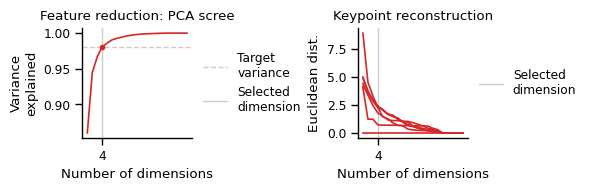

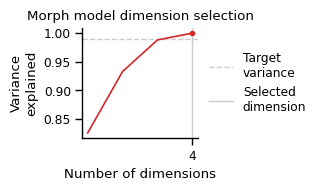

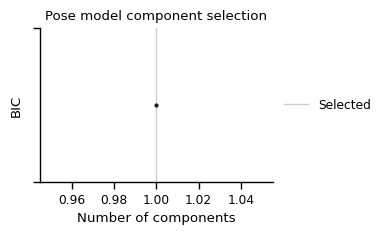

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose1/models/morph-prior-scan_2/plots/pose_calibration.pdf')

In [30]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [31]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 3e0, 1e2],
    'fit.em.learning_rate': [3e-1, 3e-2, 3e-2]
})
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "morph-prior-scan", return_session_inv=True)

#### Fitting

In [32]:
scans.run_scan(project, "morph-prior-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose1/models/morph-prior-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 300 frames
INFO:root:Adjusting learning rate:0.3 -> 9.999999999999999e-05
INFO:root:Loading LR schedule: const
INFO:root:Step 0 : loss = 75968.484375
INFO:root:Step 20 : loss = 63030.87109375
INFO:root:Step 40 : loss = 54064.1640625
INFO:root:Step 60 : loss = 49606.13671875
INFO:root:Step 80 : loss = 47630.61328125
INFO:root:Step 100 : loss = 46780.68359375
INFO:root:Step 120 : loss = 46346.87890625
INFO:root:Step 140 : loss = 46045.70703125
INFO:root:Step 160 : loss = 45817.62109375
INFO:root:Step 180 : loss = 45629.33984375
INFO:root:Step 200 : loss = 45482.828125
INFO:root:Step 220 : loss = 45370.6328125
INFO:root:Step 240 : loss = 45285.20703125
INFO:root:Step 260 : loss = 45224.8203125
INFO:root:Step 280 : loss = 45182.63671875
INFO:root:Step 300 : loss =

#### Standard training diagnostics

  0%|          | 0/5 [00:00<?, ?it/s]

Plotting init-scan_0
- reports


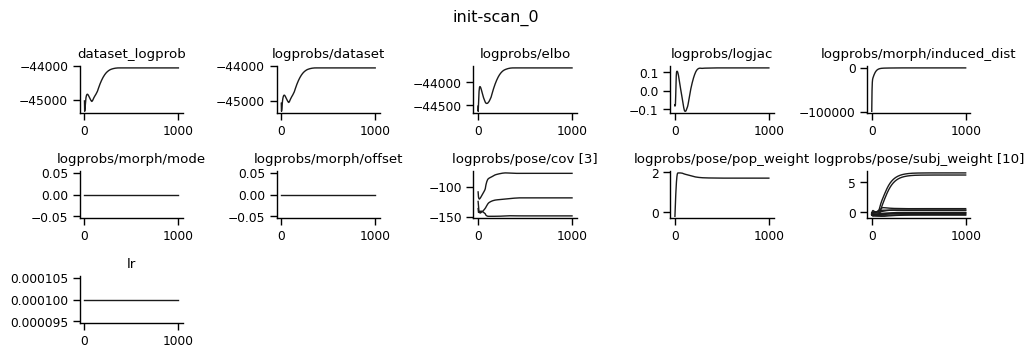

100%|██████████| 1000/1000 [00:00<00:00, 5858.78it/s]


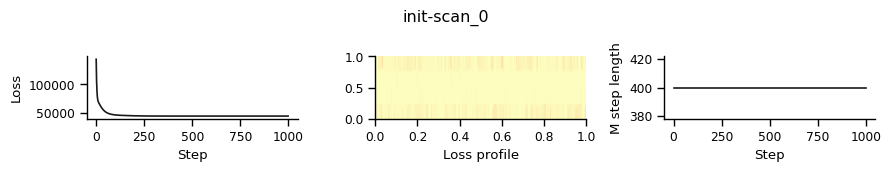

- morph


100%|██████████| 10/10 [00:00<00:00, 213.43it/s]


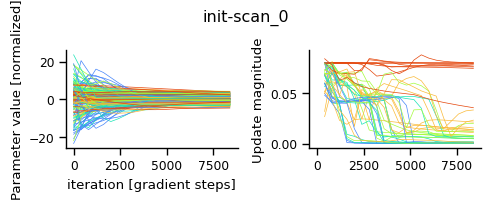

- gmm


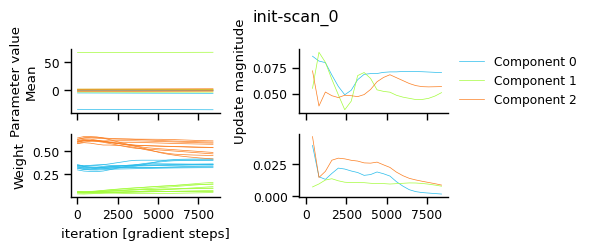

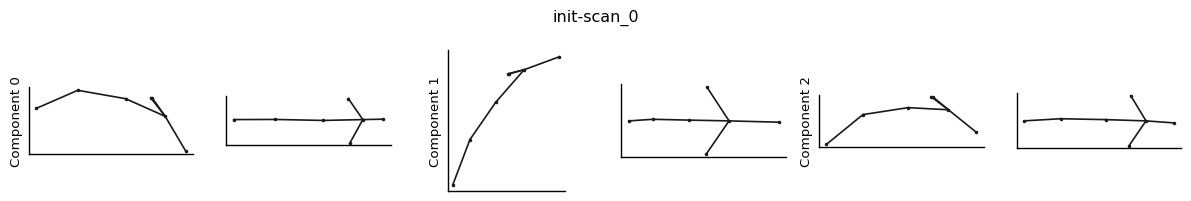

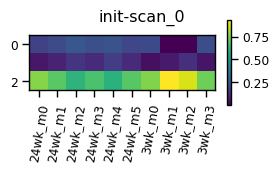

 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

Plotting init-scan_1
- reports


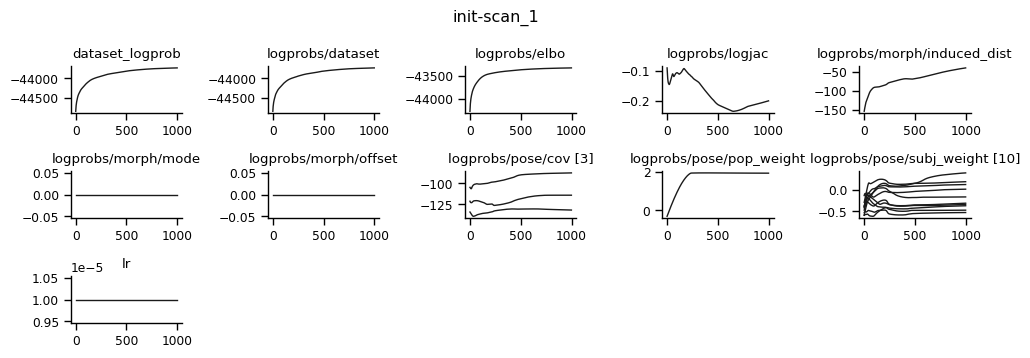

100%|██████████| 1000/1000 [00:00<00:00, 8891.17it/s]


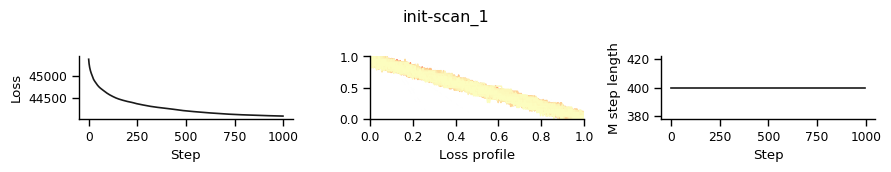

- morph


100%|██████████| 10/10 [00:00<00:00, 221.33it/s]


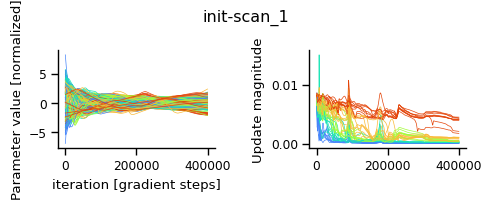

- gmm


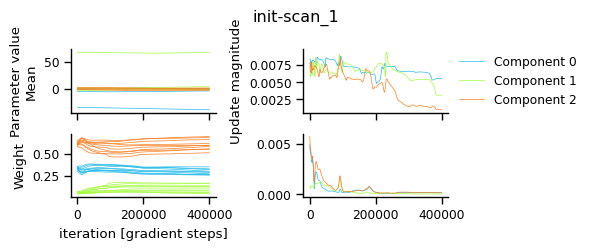

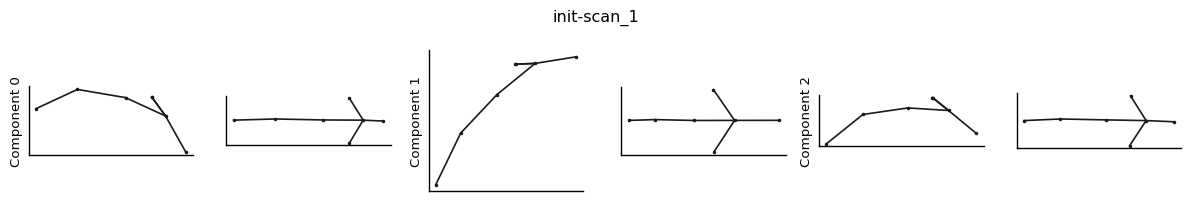

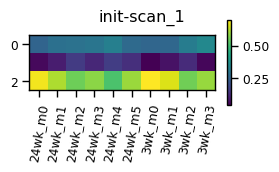

 40%|████      | 2/5 [00:04<00:06,  2.05s/it]

Plotting init-scan_2
- reports


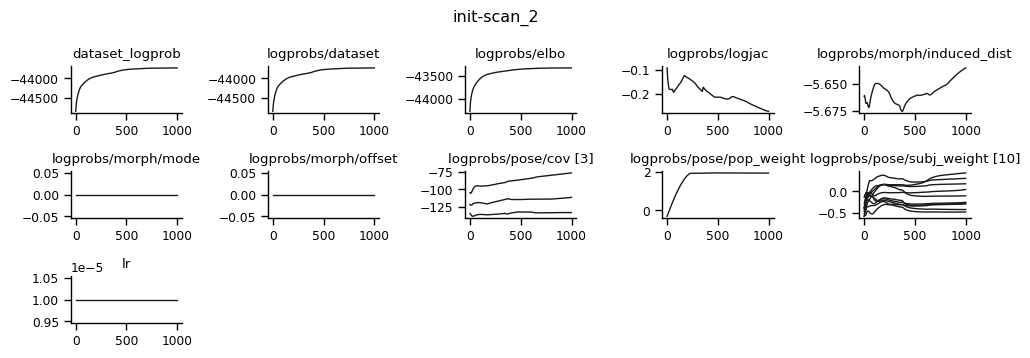

100%|██████████| 1000/1000 [00:00<00:00, 9149.54it/s]


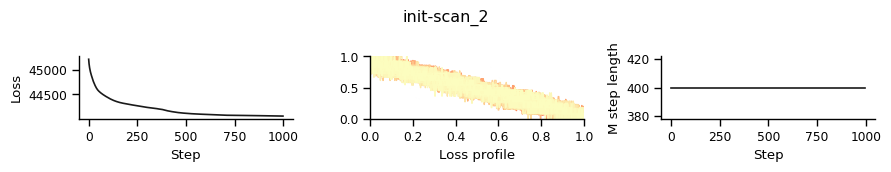

- morph


100%|██████████| 10/10 [00:00<00:00, 217.45it/s]


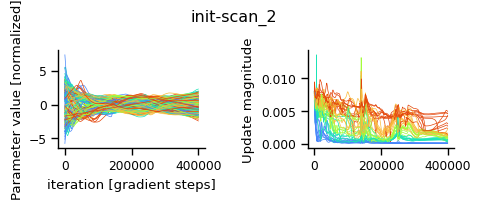

- gmm


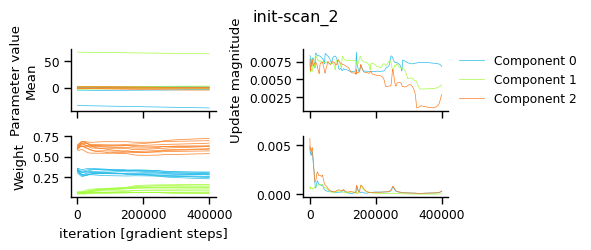

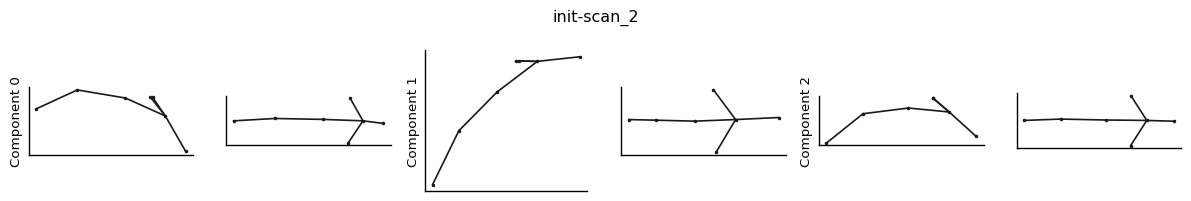

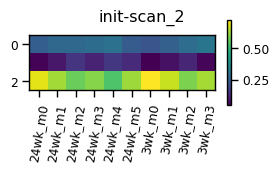

 60%|██████    | 3/5 [00:05<00:03,  1.97s/it]

Plotting init-scan_3
- reports


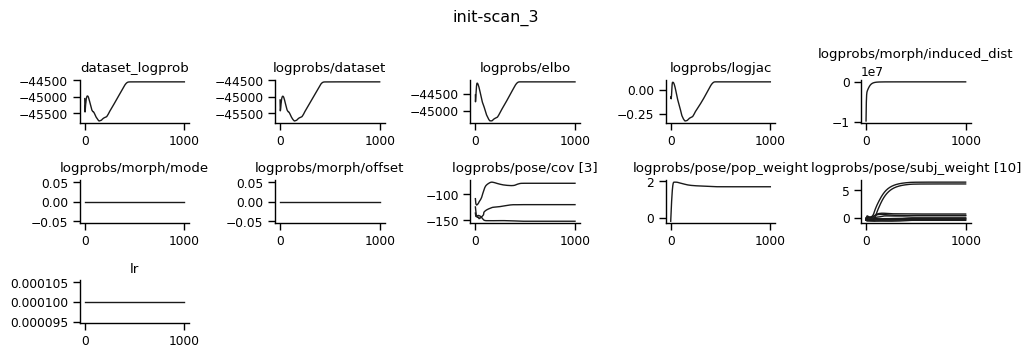

100%|██████████| 1000/1000 [00:00<00:00, 8779.25it/s]


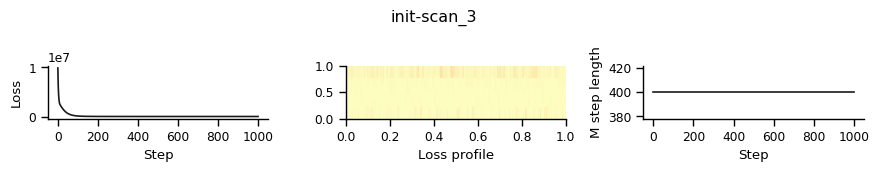

- morph


100%|██████████| 10/10 [00:00<00:00, 223.48it/s]


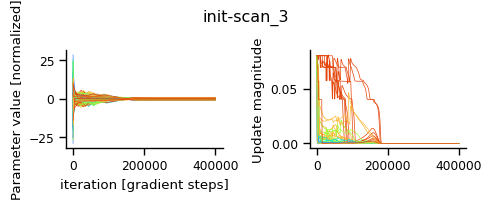

- gmm


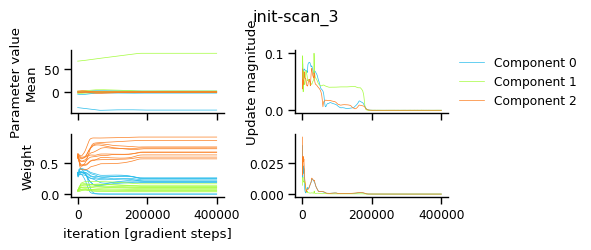

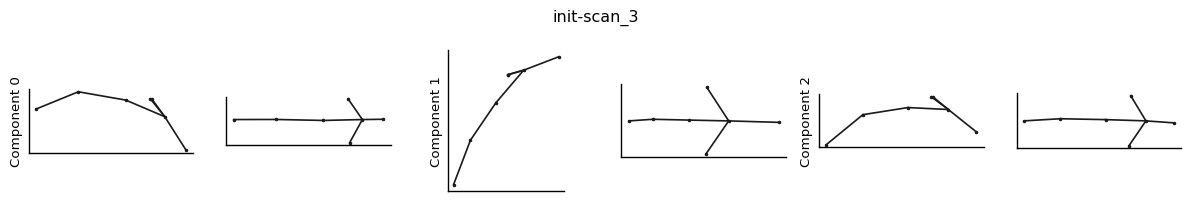

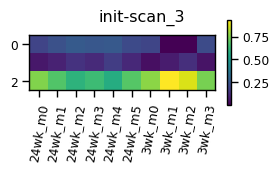

 80%|████████  | 4/5 [00:08<00:02,  2.04s/it]

Plotting init-scan_4
- reports


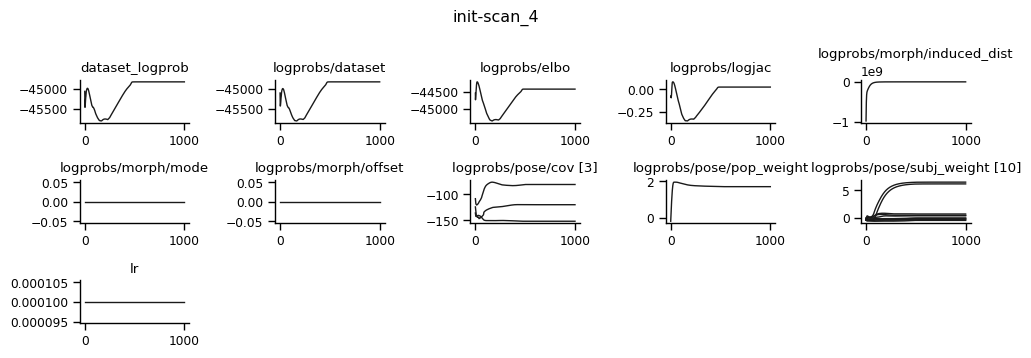

100%|██████████| 1000/1000 [00:00<00:00, 8916.65it/s]


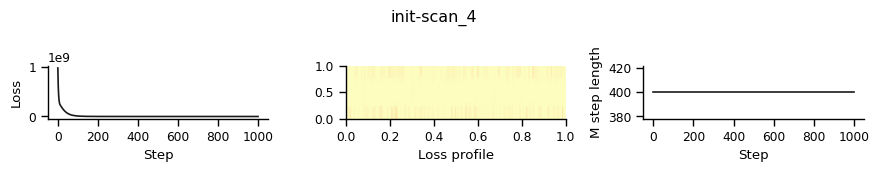

- morph


100%|██████████| 10/10 [00:00<00:00, 215.34it/s]


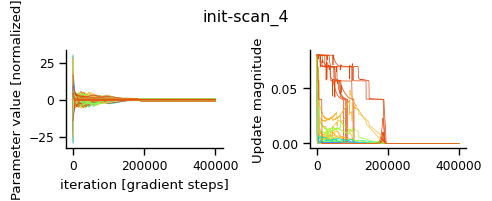

- gmm


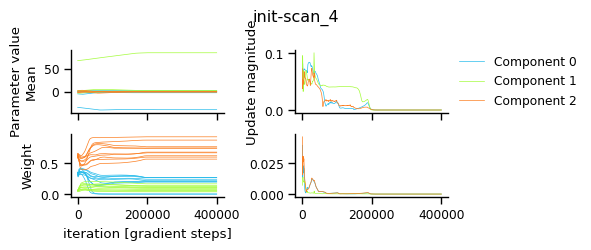

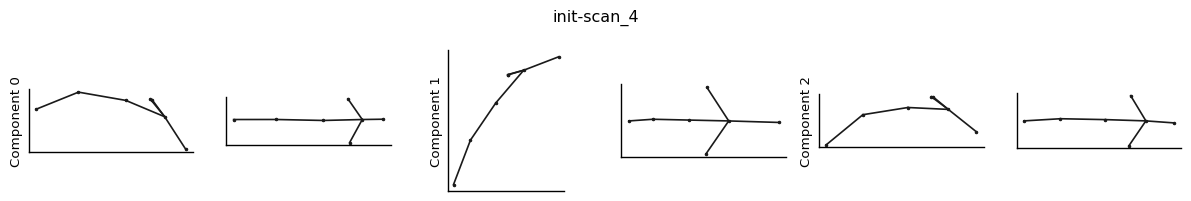

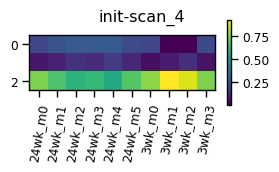

100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


In [144]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(2, 2), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(2.5, 2.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 5/5 [00:00<00:00, 25.97it/s]


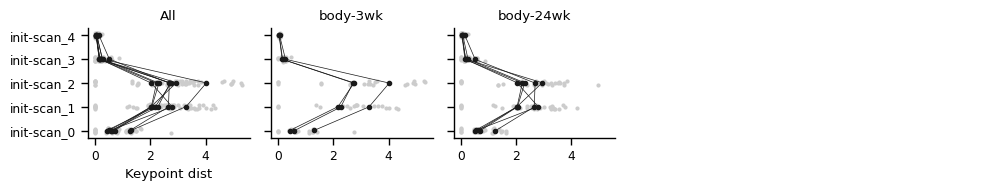

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [145]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 2/2 [00:00<00:00, 173.34it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


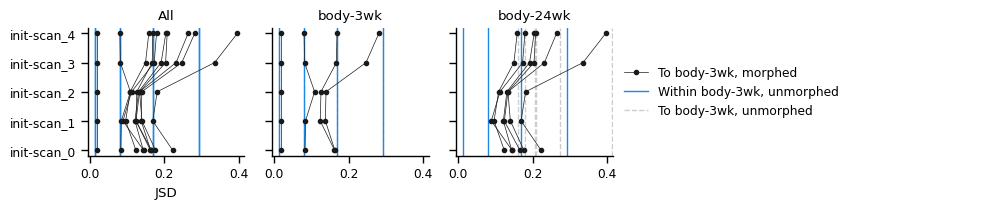

In [146]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

## Multiple GMM components

#### Project setup

In [203]:
project_config_kws, dataset_keypoints = load_all_mouse_sessions(["3", "24"])
ref_age = "3"
ref_session = f"{ref_age}wk_m0"
project_config_kws['ref_session'] = ref_session


sessions: dict_keys(['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '3wk_m1', '3wk_m0', '24wk_m4', '3wk_m2', '3wk_m3', '24wk_m5'])


In [204]:
# Create base project config to override

project_dir = Path('../projects/ont-test/3-24')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



#### Calibration and training setup

In [205]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=300,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98
cfg['alignment']['rescale_mode'] = 'body'

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 2000
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames
INFO:root:Fitting GMM to 300 frames


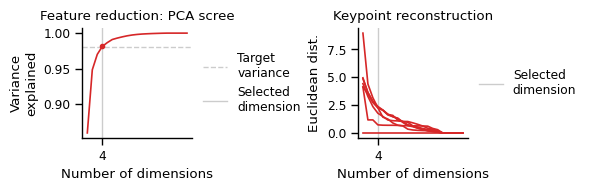

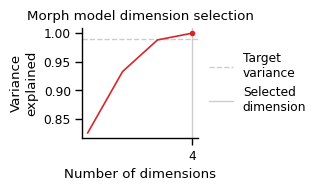

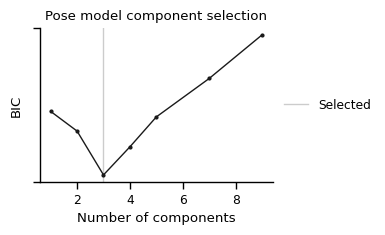

PosixPath('../projects/ont-test/3-24/plots/pose_calibration.pdf')

In [206]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [207]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 3e0, 1e2],
    'fit.em.learning_rate': [3e-1, 3e-2, 3e-2]
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "init-scan", {
    'morph.dist_var': [1e-2, 1e-1, 3e0],
    'fit.em.learning_rate': [3e-1, 3e-1, 3e-2],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
    'fit.em.n_steps': [1000, 1000, 1000],
})

cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "init-scan", return_session_inv=True)

#### Fitting

In [208]:
scans.run_scan(project, "init-scan", scan_dataset, log_every=20, force_restart=False)

INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 300 frames
INFO:root:Adjusting learning rate:0.3 -> 9.999999999999999e-05
INFO:root:Loading LR schedule: const
INFO:root:Scaling param: pose/subj_weight_logits,shape (10, 3) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (3,) by 10.0
INFO:root:Scaling param: pose/means,shape (3, 4) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (3, 10) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (10, 4, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (10, 4)
INFO:root:Scaling param: pose/subj_weight_logits,shape (10, 3) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (3,) by 10.0
INFO:root:Scaling param: pose/means,shape (3, 4) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (3, 10) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (10, 4, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (10, 4)
INFO:root:Step 0 : loss = 111

#### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting init-scan_0
- reports


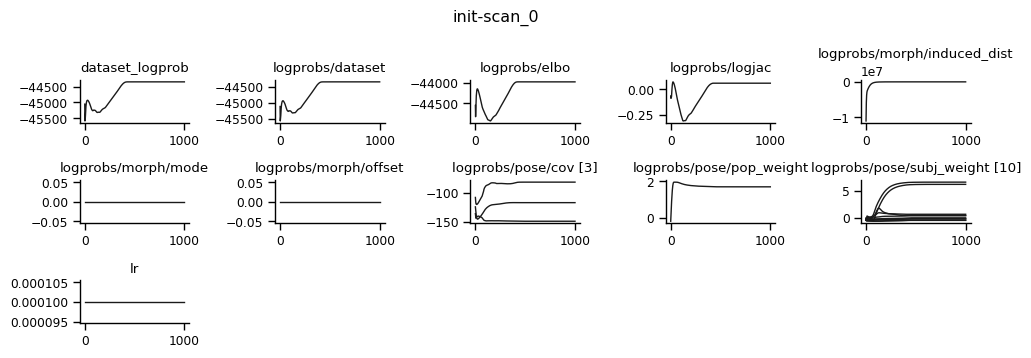

100%|██████████| 1000/1000 [00:00<00:00, 8965.89it/s]


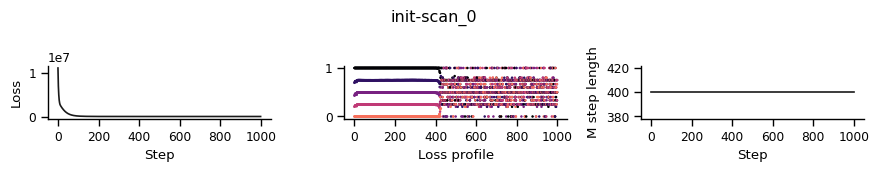

- morph


100%|██████████| 10/10 [00:00<00:00, 153.30it/s]


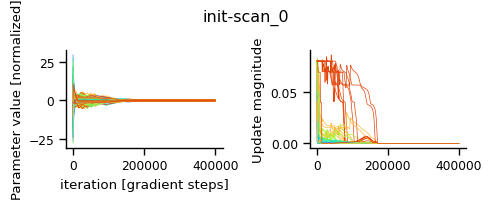

- gmm


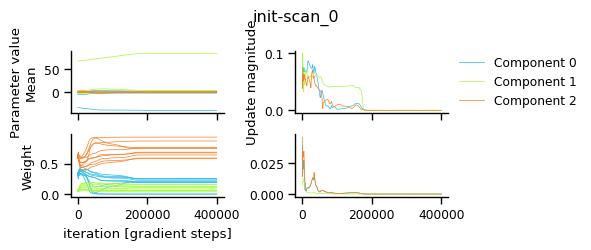

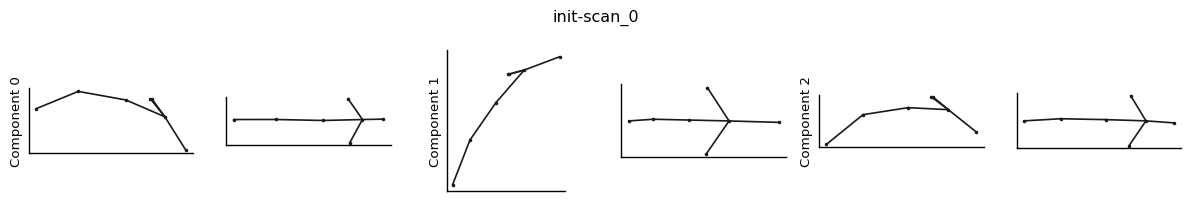

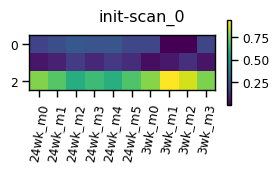

 33%|███▎      | 1/3 [00:01<00:03,  1.98s/it]

Plotting init-scan_1
- reports


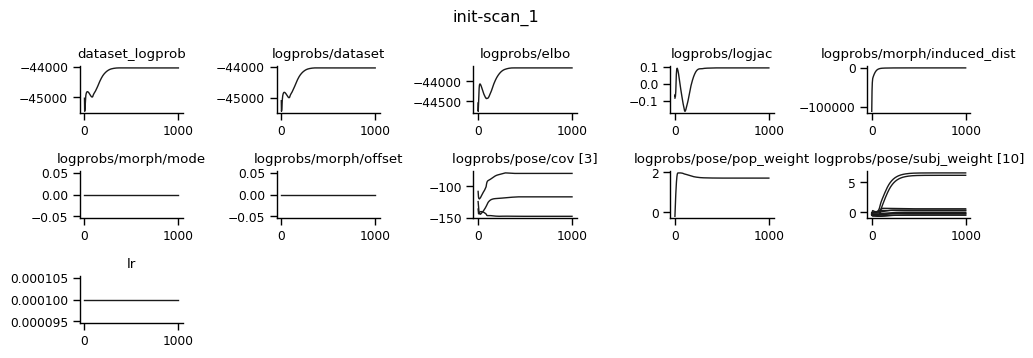

100%|██████████| 1000/1000 [00:00<00:00, 9024.43it/s]


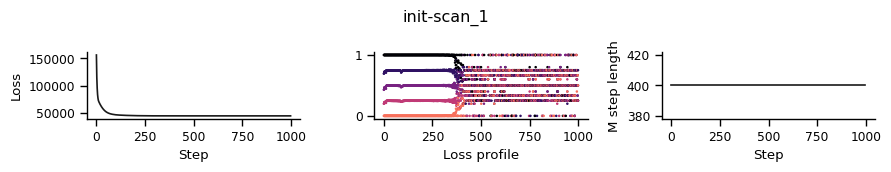

- morph


100%|██████████| 10/10 [00:00<00:00, 207.97it/s]


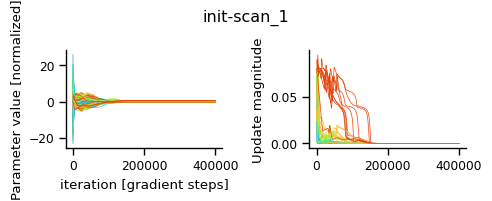

- gmm


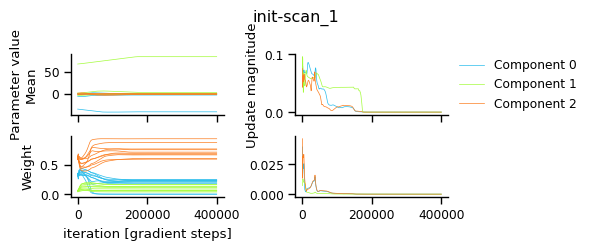

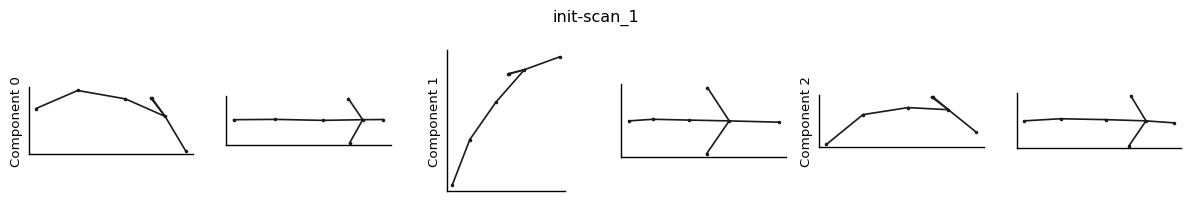

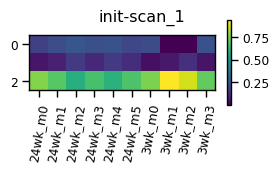

 67%|██████▋   | 2/3 [00:04<00:02,  2.02s/it]

Plotting init-scan_2
- reports


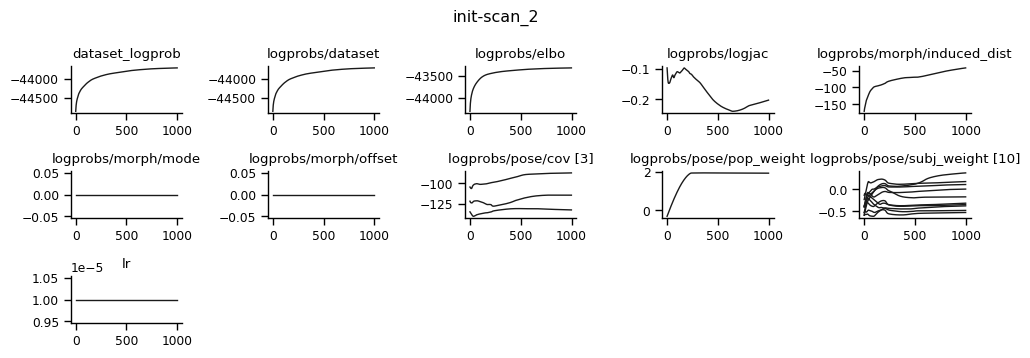

100%|██████████| 1000/1000 [00:00<00:00, 8639.25it/s]


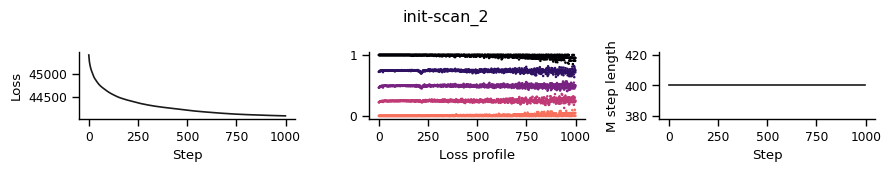

- morph


100%|██████████| 10/10 [00:00<00:00, 229.06it/s]


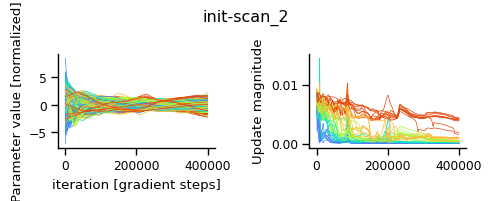

- gmm


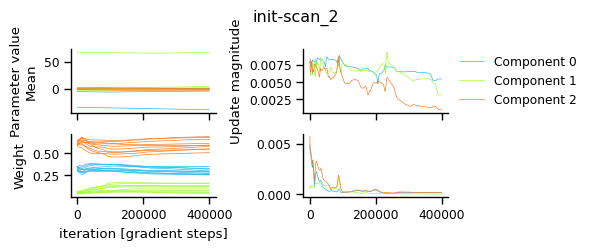

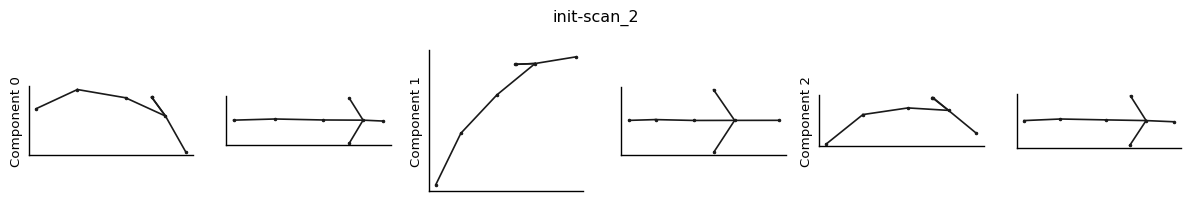

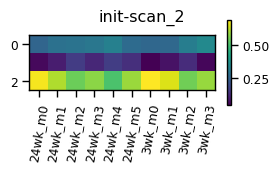

100%|██████████| 3/3 [00:05<00:00,  1.95s/it]


In [209]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt, final_mstep=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(2, 2), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(2.5, 2.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 24.99it/s]


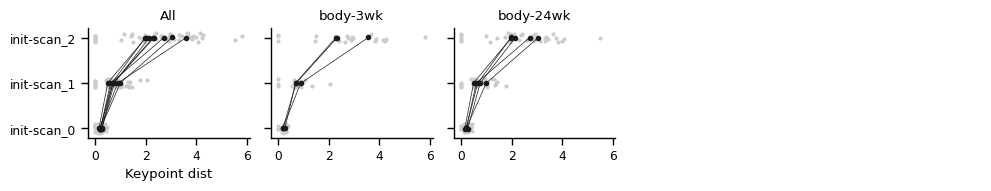

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [210]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 2/2 [00:00<00:00, 158.33it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


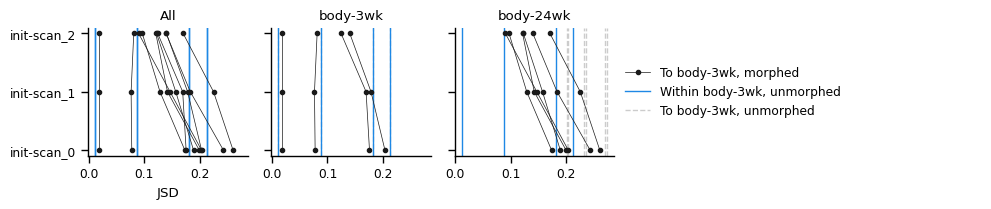

In [211]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

## Specified many GMM components

For comparison to supervised ethogram

#### Project setup

In [542]:
project_config_kws, dataset_keypoints = load_all_mouse_sessions(["3", "24"])
ref_age = "3"
ref_session = f"{ref_age}wk_m0"
project_config_kws['ref_session'] = ref_session


sessions: dict_keys(['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '3wk_m1', '3wk_m0', '24wk_m4', '3wk_m2', '3wk_m3', '24wk_m5'])


In [543]:
# Create base project config to override

project_dir = Path('../projects/ont-test/3-24-pose10')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

plot_dir = project_dir / "plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf')



#### Calibration and training setup

In [544]:
loaders.arrays.setup_project_config(
    project.main_config(),
    feature_type='pcs',
    alignment_type='sagittal',
    exclude_keypoints=[
        't_base', 'lr_knee', 'lr_foot', 'rr_knee', 'rr_foot',
        'lf_foot', 'rf_foot', 't_tip'
        # 't_tip',
    ],
    subsample_to=300,
    **project_config_kws,)

setup.setup_base_model_config(project.main_config(), project.base_model_config())

# --- calibration: alignment and feature reduction
cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
cfg['features']['calibration']['tgt_variance'] = 0.98
cfg['alignment']['rescale_mode'] = 'body'

dataset, cfg = alignment.sagittal.calibrate(
    dataset, cfg, origin='hips', anterior='head'
)

# generating morph modifies within first 5 PCs
cfg = features.pcs.calibrate(dataset, cfg)
dataset = features.reduce_to_features(dataset, cfg["features"])
config.save_project_config(project.main_config(), cfg, write_calib=True)

# --- calibration: pose and morph models
cfg = config.load_model_config(project.base_model_config())
cfg["morph"]["prior_mode"] = "distance"
cfg["morph"]["calibration"]["tgt_variance"] = 0.99
cfg["pose"]["calibration"]["n_iter"] = 9
cfg["pose"]["calibration"]["max_components"] = 10
cfg["pose"]["subj_weight_uniformity"] = 1
cfg["fit"]["n_steps"] = 2000
cfg["fit"]["learning_rate"] = 1e-1
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["mstep"]["tol"] = None
cfg["fit"]["update_scales"] = {'pose/*': 1e1}

# simplify training: know no distribution difference
cfg = pose.gmm.calibrate_base_model(dataset, cfg, n_components=10)
cfg = morph.lowrank_affine.calibrate_base_model(dataset, cfg)
cfg = em.calibrate_base_model(dataset, cfg)
config.save_model_config(project.base_model_config(), cfg, write_calib=True)

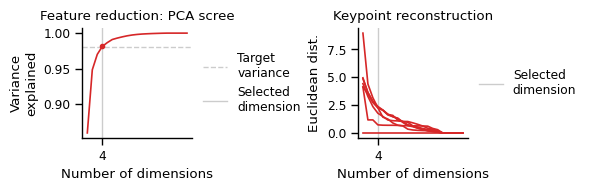

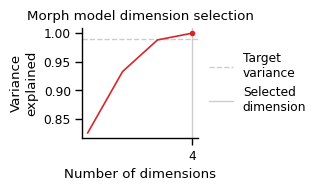

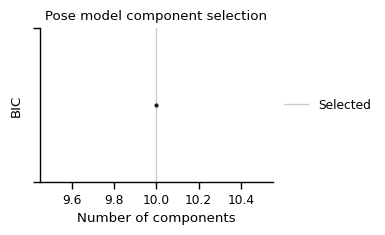

PosixPath('../projects/ont-test/3-24-pose10/plots/pose_calibration.pdf')

In [414]:
cfg = config.load_model_config(project.base_model_config())

fig = features.pcs.plot_calibration(cfg)
plotter.finalize(fig, "feature_calibration")

figs = viz.model.plot_calibration(cfg)
plotter.finalize(figs["morph"], "morph_calibration")
plotter.finalize(figs["pose"], "pose_calibration")

In [552]:
scan_cfg, model_cfg = scans.setup_scan_config(project, "morph-prior-scan", {
    'morph.dist_var': [1e-1, 3e0, 1e2],
    'fit.em.learning_rate': [3e-1, 3e-2, 3e-2]
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "init-scan", {
    'morph.dist_var': [1e-2, 1e-1, 3e0],
    'fit.em.learning_rate': [3e-1, 3e-1, 3e-2],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
    'fit.em.n_steps': [1500, 1500, 1500],
})

scan_cfg, model_cfg = scans.setup_scan_config(project, "unif-scan", {
    'morph.dist_var': [1e-1, 1e-1, 1e-1],
    'fit.em.learning_rate': [3e-1, 3e-1, 3e-2],
    'morph.init.type': ['covariance', 'covariance', 'covariance'],
    'fit.em.n_steps': [1500, 1500, 1500],
    'pose.subj_weight_uniformity': [1, 10, 100],
})

cfg = config.load_project_config(project.main_config())
dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
scan_dataset, split_meta, _ = scans.prepare_scan_dataset(dataset, project, "unif-scan", return_session_inv=True)

#### Fitting

In [553]:
scans.run_scan(project, "unif-scan", scan_dataset, log_every=20, force_restart=True)

INFO:root:Removing existing model /Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_0
INFO:root:Initializing morph model
INFO:root:Initializing pose model
INFO:root:Fitting GMM to 300 frames
INFO:root:Adjusting learning rate:0.3 -> 9.999999999999999e-05
INFO:root:Loading LR schedule: const
INFO:root:Scaling param: pose/subj_weight_logits,shape (10, 10) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (10,) by 10.0
INFO:root:Scaling param: pose/means,shape (10, 4) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (10, 10) by 10.0
INFO:root:Unscaled param: morph/_mode_updates, shape (10, 4, 4)
INFO:root:Unscaled param: morph/_offset_updates, shape (10, 4)
INFO:root:Scaling param: pose/subj_weight_logits,shape (10, 10) by 10.0
INFO:root:Scaling param: pose/pop_weight_logits,shape (10,) by 10.0
INFO:root:Scaling param: pose/means,shape (10, 4) by 10.0
INFO:root:Scaling param: pose/cholesky,shape (10, 10) by 10.0
INFO:root:Unscaled

#### Standard training diagnostics

  0%|          | 0/3 [00:00<?, ?it/s]

Plotting unif-scan_0
- reports


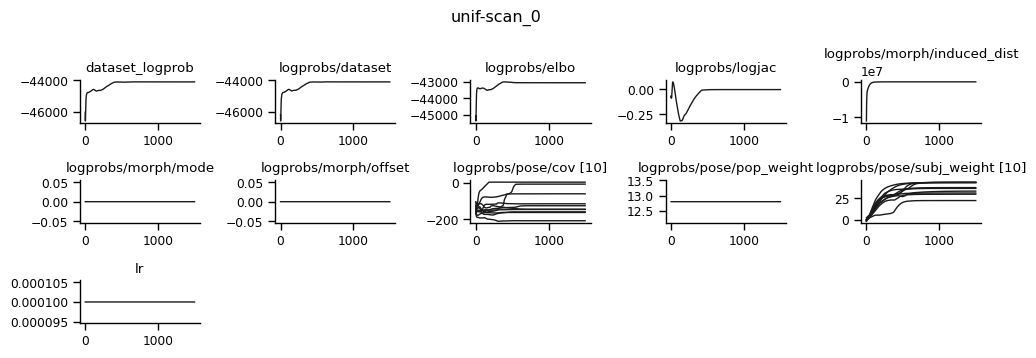

100%|██████████| 1500/1500 [00:00<00:00, 4565.12it/s]


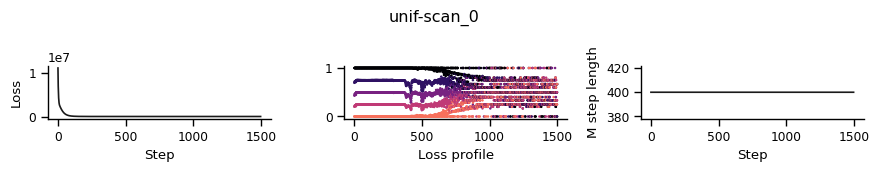

- morph


100%|██████████| 10/10 [00:00<00:00, 148.28it/s]


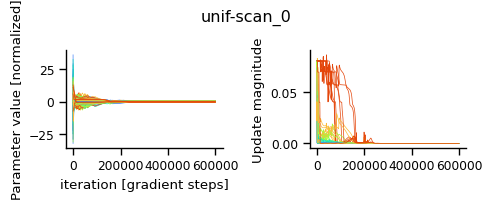

- gmm


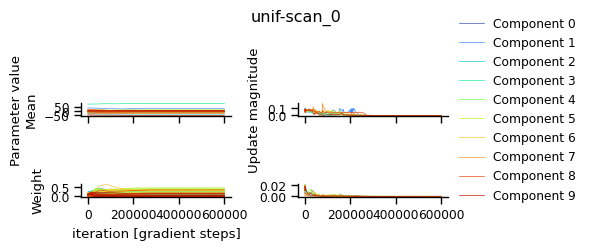

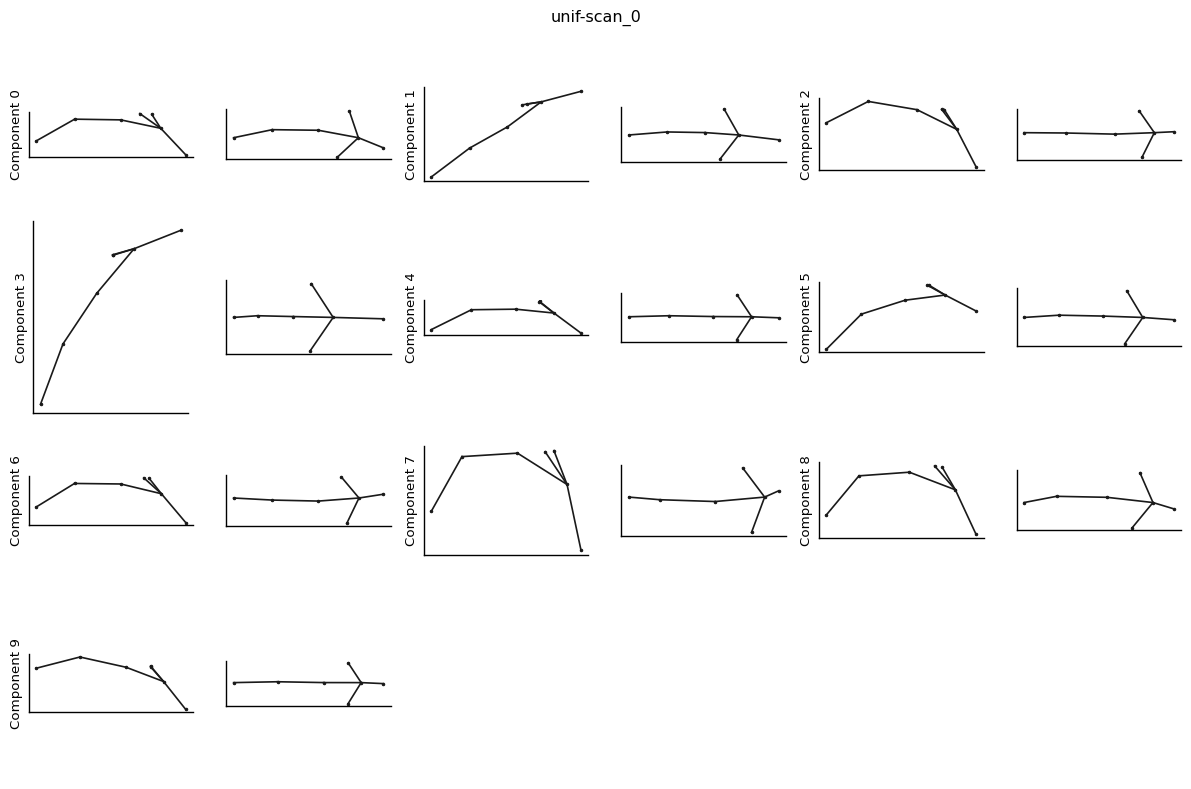

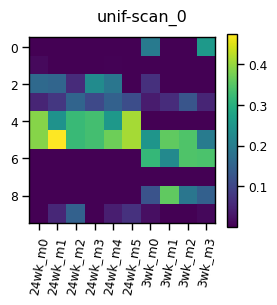

 33%|███▎      | 1/3 [00:02<00:05,  2.70s/it]

Plotting unif-scan_1
- reports


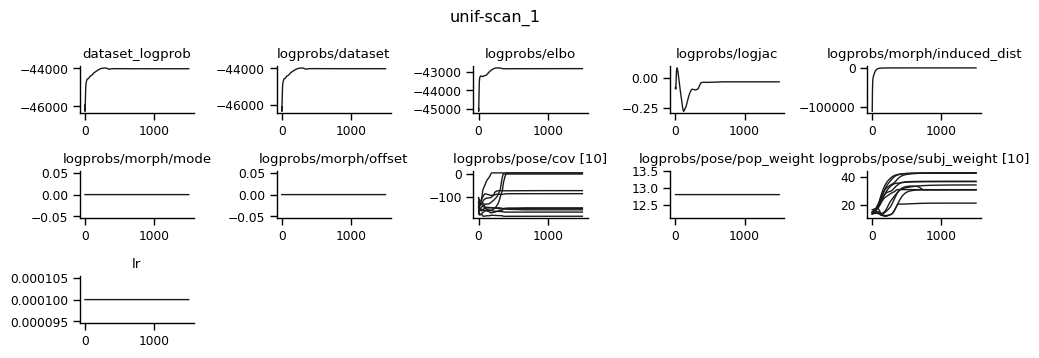

100%|██████████| 1500/1500 [00:00<00:00, 8927.84it/s]


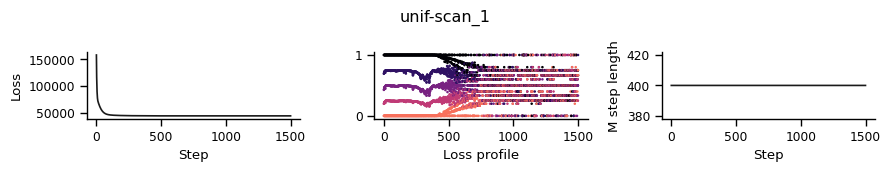

- morph


100%|██████████| 10/10 [00:00<00:00, 206.68it/s]


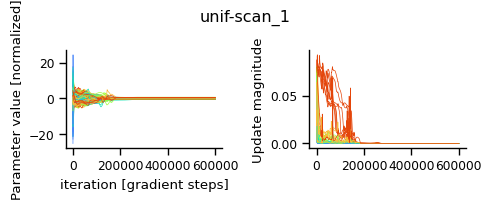

- gmm


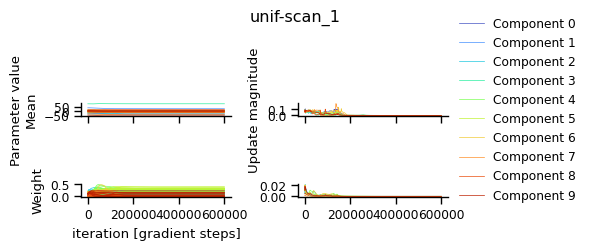

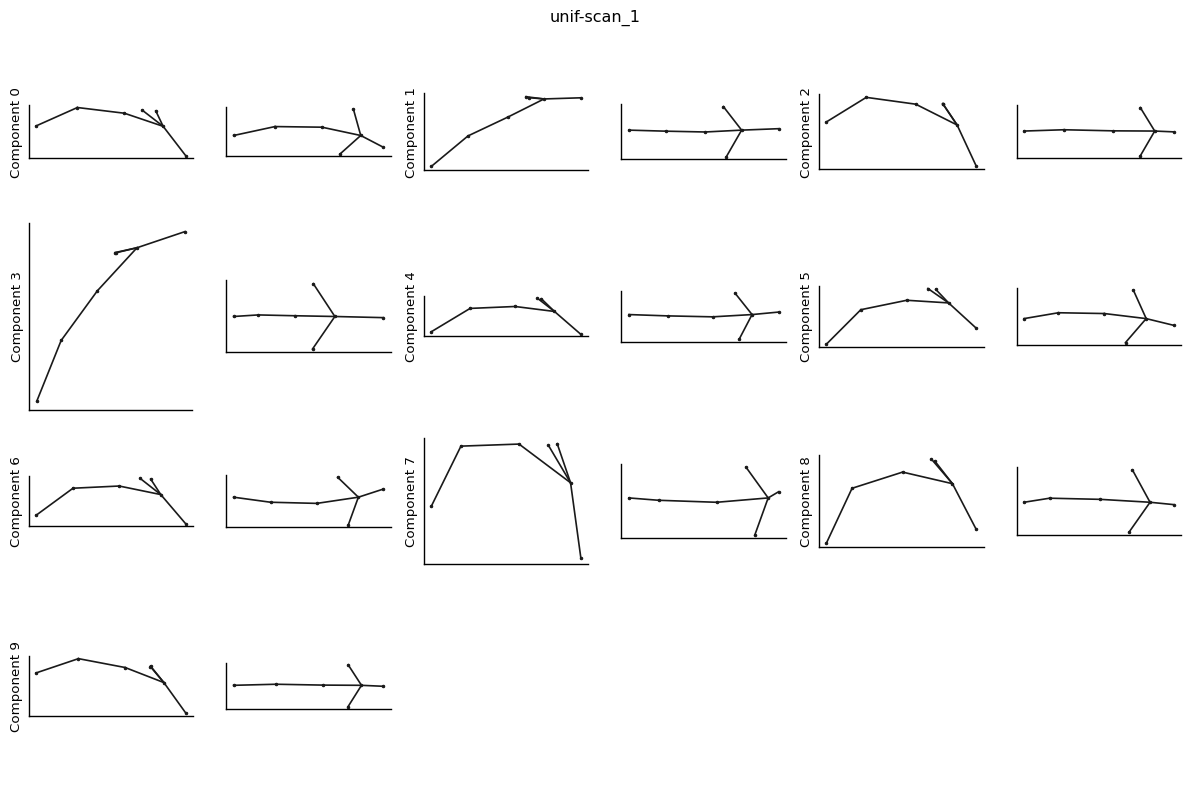

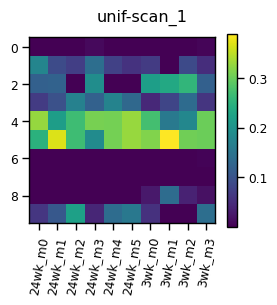

 67%|██████▋   | 2/3 [00:05<00:02,  2.74s/it]

Plotting unif-scan_2
- reports


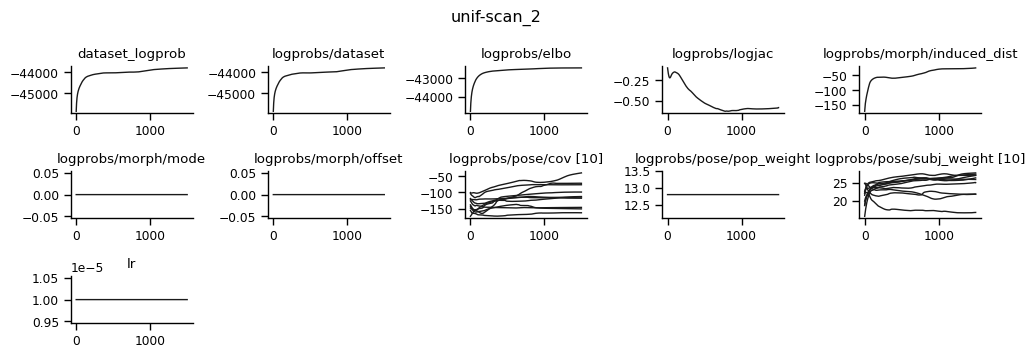

100%|██████████| 1500/1500 [00:00<00:00, 9020.67it/s]


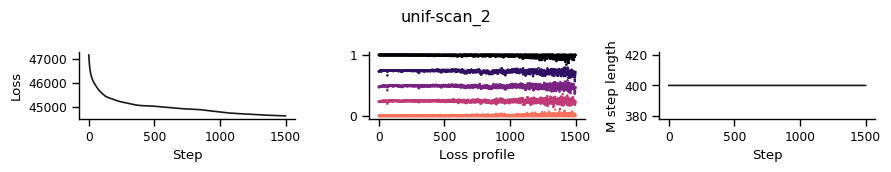

- morph


100%|██████████| 10/10 [00:00<00:00, 187.68it/s]


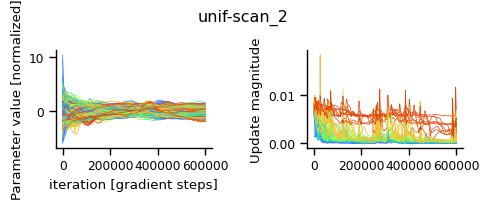

- gmm


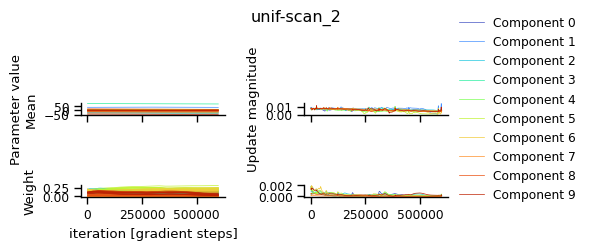

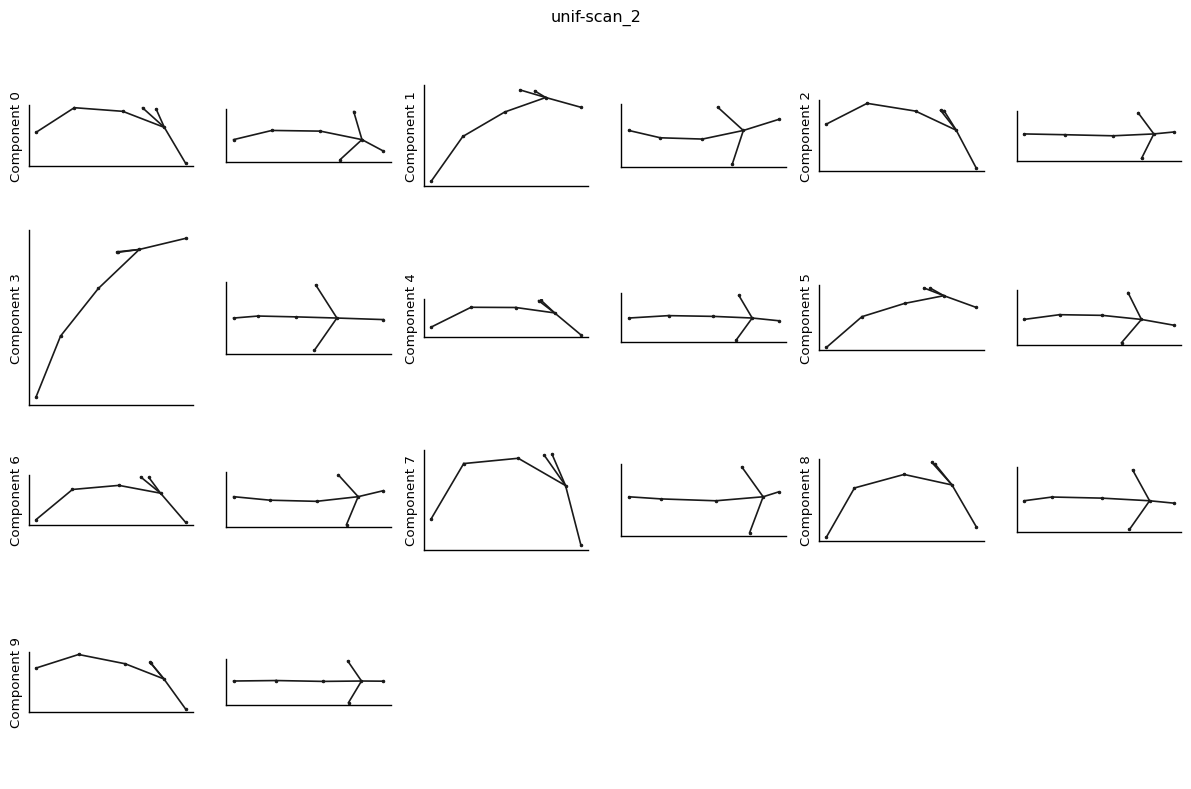

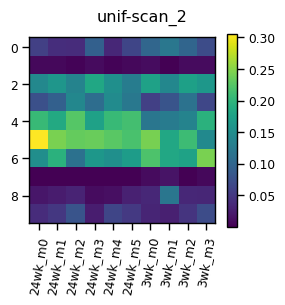

100%|██████████| 3/3 [00:08<00:00,  2.68s/it]


In [549]:
progress = True
models = list(scan_cfg['models'].keys())

for model_name in model_util._optional_pbar(models, progress):

    print("Plotting", model_name)
    ckpt = methods.load_fit(project.model(model_name))
    ckpt["config"] = config.load_model_config(project.model_config(model_name))
    (project.model(model_name) / "plots").mkdir(exist_ok = True)
    plotter.plot_dir = str(project.model(model_name) / "plots")

    print("- reports")
    fig = viz.model.report_plots(ckpt, first_step=0, ax_size=(2, 1.2))
    fig.suptitle(model_name)
    plotter.finalize(fig, "reports")

    fig = viz.model.em_loss(ckpt, final_mstep=True)
    fig.suptitle(model_name)
    plotter.finalize(fig, "em_loss")

    print("- morph")
    fig = viz.model.lra_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, ax_size=(2, 2), legend=False)
    fig.suptitle(model_name)
    plotter.finalize(fig, "morph_convergence")

    print("- gmm")
    fig = viz.model.gmm_param_convergence(ckpt, progress = True, dataset=scan_dataset, magnitude_only=True, normalize=False, ax_size=(2.5, 2.5))
    fig.suptitle(model_name)
    plotter.finalize(fig, "gmm_convergence")

    mean_fig, wt_fig = viz.model.gmm_components(ckpt, dataset=scan_dataset)
    mean_fig.suptitle(model_name)
    wt_fig.suptitle(model_name)
    plotter.finalize(mean_fig, "gmm_means")

100%|██████████| 3/3 [00:00<00:00, 16.83it/s]


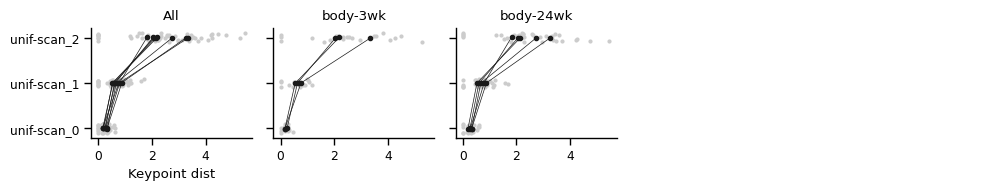

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/scans/morph-prior-scan/plots/reconst_errs.pdf')

In [550]:
fig = viz.scans.withinbody_induced_errs(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
plot_dir = (project.scan('morph-prior-scan') / "plots")
plot_dir.mkdir(exist_ok = True)
plotter.plot_dir = str(plot_dir)
plotter.finalize(fig, "reconst_errs")

Unmorphed: 100%|██████████| 2/2 [00:00<00:00, 167.24it/s]
/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  fig.tight_layout()


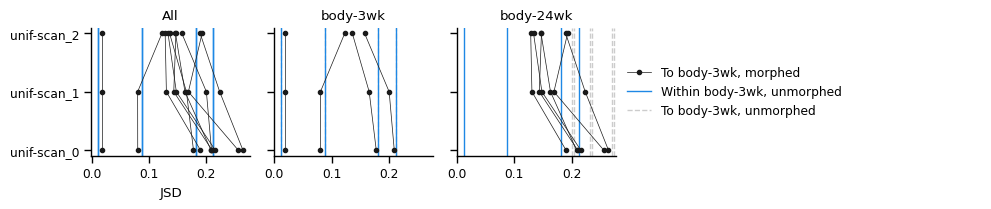

In [551]:
fig = viz.scans.jsds_to_reference(project, models, progress = True, dataset=scan_dataset, split_meta=split_meta)
ax = fig.get_axes()
plotter.finalize(fig, None)

## Figure panels

#### Setup

In [556]:
project_config_kws, dataset_keypoints = load_all_mouse_sessions(["3", "24"])
ref_age = "3"
ref_session = f"{ref_age}wk_m0"
project_config_kws['ref_session'] = ref_session

ref_age = '3'
tgt_age = '24'
tgt_ages = ['24']
ref_color = getc('curl_pink:180')
tgt_color = getc('curl_pink:60')
tgt_colors = [getc('curl_pink:60')]

sessions: dict_keys(['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '3wk_m1', '3wk_m0', '24wk_m4', '3wk_m2', '3wk_m3', '24wk_m5'])


In [742]:
# Create base project config to override

project_dir = Path('../projects/ont-test/3-24-pose10')
project_dir.mkdir(exist_ok = True)
project = Project(project_dir)

scan_name = 'unif-scan'
model_name = 'unif-scan_1'

plot_dir = project.model(model_name) / "panel-plots"
plot_dir.mkdir(exist_ok = True)
plotter, colors = styles.init_nb(str(plot_dir), style = "default", fmt = 'pdf', transparent=True, dpi=1200)



In [558]:
def merge_morphs(params: LRAParams, merged_session_meta: SessionMetadata, split_session_meta: SessionMetadata, split_meta: dict):
    """
    Merge morph parameters from a split dataset into a single dataset.

    Parameters
    ----------
    params : LRAParams
        The morph parameters.
    merged_session_meta, split_session_metadata : SessionMetadata
        Session metadata object (accessible via dataset.session_meta) for
        identifying body ids.
    split_meta : dict
        Metadata for the split dataset, containing a mapping original body names
        to sessions in the split dataset.

    Returns
    -------
    numpy.ndarray, shape (n_sessions, n_modes, n_dims)
        The merged morph parameters.
    """
    body_inv = {
        b: [split_session_meta.session_body_name(s) for s in split_meta[b]]
        for b in split_meta
    }
    new_nbod = len(merged_session_meta._body_ids)
    new_ref = None
    mode_upds = np.zeros((new_nbod, params.n_feats, params.n_dims))
    ofs_upds = np.zeros((new_nbod, params.n_dims))
    for i in range(new_nbod):
        merged_bod = merged_session_meta.body_name(i)
        i_mode_upds = []
        i_ofs_upds = []
        for split_bod in body_inv[merged_bod]:
            j = split_session_meta.body_id(split_bod)
            i_mode_upds.append(params.mode_updates[j])
            i_ofs_upds.append(params.offset_updates[j])
            if j == params.ref_body:
                new_ref = i
        mode_upds[i] = np.mean(i_mode_upds, axis=0)
        ofs_upds[i] = np.mean(i_ofs_upds, axis=0)
    
    return LRAParams({**params._tree, **dict(
        n_bodies=new_nbod,
        ref_body=new_ref,
        _mode_updates=jnp.array(mode_upds),
        _offset_updates=jnp.array(ofs_upds),
    )})

    


In [570]:
# Select and load model

ckpt = methods.load_fit(project.model(model_name))
cfg = ckpt["config"]
model = instantiation.get_model(cfg)
arms = Armature.from_config(cfg["dataset"])
params = ckpt["params"]
merged_params = merge_morphs(params.morph, dataset.session_meta, scan_dataset.session_meta, split_meta[0])

dataset = loaders.arrays.from_arrays(dataset_keypoints, cfg["dataset"])
dataset_versions, split_meta, align_meta = scans.prepare_scan_dataset(dataset, project, scan_name, return_session_inv=True, all_versions=True)
scan_dataset = dataset_versions["train"]
dataset_feats = dataset_versions["reduced"]

In [560]:
# Select and load model
naive_proj_dir = Path('../projects/ont-test/3-24-pose1')
naive_proj_dir.mkdir(exist_ok = True)
naive_proj = Project(naive_proj_dir)

naive_scan_name = 'morph-prior-scan'
naive_model_name = 'morph-prior-scan_1'

naive_ckpt = methods.load_fit(naive_proj.model(naive_model_name))
naive_cfg = naive_ckpt["config"]
naive_model = instantiation.get_model(naive_cfg)
naive_arms = Armature.from_config(naive_cfg["dataset"])
naive_params = naive_ckpt["params"]

naive_dataset = loaders.arrays.from_arrays(dataset_keypoints, naive_cfg["dataset"])
naive_dataset_versions, naive_split_meta, naive_align_meta = scans.prepare_scan_dataset(dataset, project, scan_name, return_session_inv=True, all_versions=True)
naive_scan_dataset = naive_dataset_versions["train"]
naive_dataset_feats = dataset_versions["reduced"]
naive_merged_params = merge_morphs(naive_params.morph, naive_dataset.session_meta, naive_scan_dataset.session_meta, naive_split_meta[0])

In [745]:
plt.rcParams.update({
    # font
    'font.family': 'Arial',
    'font.size': 6,
    'axes.labelsize': 6,
    'xtick.labelsize': 5.5,
    'ytick.labelsize': 5.5,
    'axes.titlesize': 6,
    'legend.fontsize': 5.5,
    'figure.titlesize': 6,
    # axes
    'axes.facecolor': 'ffffff00',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.linewidth': 0.25,
    'xtick.major.width': 0.2,
    'ytick.major.width': 0.2,
    'xtick.minor.width': 0.15,
    'ytick.minor.width': 0.15,
    'xtick.major.pad': 1.5,
    'ytick.major.pad': 1.5,
    'xtick.major.size': 1.2,
    'ytick.major.size': 1.2,
    'xtick.minor.size': 1,
    'ytick.minor.size': 1,
    # legend
    'legend.frameon': False,
    # misc
    'hatch.linewidth': 0.5,
})

#### Supporting funcs

In [652]:
def canonicalized_and_raw(dataset, morph_params, rescale=True, scale_to=None):
    canonicalized = model_util.apply_bodies(
        model.morph,
        morph_params,
        dataset,
        {
            s: dataset.session_body_name(dataset.ref_session)
            for s in dataset.sessions
        },
    )
    canonicalized = features.inflate(canonicalized, cfg["features"])
    raw = features.inflate(dataset, cfg["features"])

    if rescale:
        raw, split_align_meta = unalign_scales(
            align_meta, raw, split_meta, dataset
        )
        align_to = split_align_meta["scale"][dataset.session_id(scale_to)]
        canonical_meta = {"scale": np.full(dataset.n_sessions, align_to)}
        canonicalized, _ = unalign_scales(canonical_meta, canonicalized)
    return canonicalized, raw, (split_align_meta if rescale else {})


def canonicalized_raw_bls(
    canonicalized, raw, sessions, group_suffix='wk', parts=(".0", ".1"), group_bodies=True
):
    groups = (
        {s: re.search(r"(\d+)"+group_suffix, s).group(1) for s in sessions}
        if group_bodies
        else {s: s for s in sessions}
    )
    bls_canon = {g: [] for g in set(groups.values())}
    bls_raw = {g: [] for g in set(groups.values())}
    print("groups:", groups)
    for s in sessions:
        k = groups[s]
        bls_canon[k].extend(
            [
                _bone_lengths(canonicalized.get_session(f"{s}{part}"), arms)
                for part in parts
            ]
        )
        bls_raw[k].extend(
            [
                _bone_lengths(raw.get_session(f"{s}{part}"), arms)
                for part in parts
            ]
        )
    bls_canon = {k: jnp.concatenate(v) for k, v in bls_canon.items()}
    bls_raw = {k: jnp.concatenate(v) for k, v in bls_raw.items()}
    return bls_canon, bls_raw, groups

def canonicalized_and_raw_jas(
    canonicalized, raw, sessions, group_suffix='wk', parts=(".0", ".1"), group_bodies=True
):
    groups = (
        {s: re.search(r"(\d+)"+group_suffix, s).group(1) for s in sessions}
        if group_bodies
        else {s: s for s in sessions}
    )
    jas_canon = {g: [] for g in set(groups.values())}
    jas_raw = {g: [] for g in set(groups.values())}
    print("groups:", groups)
    for s in sessions:
        k = groups[s]
        jas_canon[k].extend(
            [
                _joint_angles(canonicalized.get_session(f"{s}{part}"), arms)
                for part in parts
            ]
        )
        jas_raw[k].extend(
            [
                _joint_angles(raw.get_session(f"{s}{part}"), arms)
                for part in parts
            ]
        )
    jas_canon = {k: jnp.concatenate(v) for k, v in jas_canon.items()}
    jas_raw = {k: jnp.concatenate(v) for k, v in jas_raw.items()}
    return jas_canon, jas_raw, groups



cfg = config.load_project_config(project.main_config())
arms = Armature.from_config(cfg["dataset"])
_bone_lengths = lambda kpts, arms: jnp.linalg.norm(
    kpts[..., arms.bones[:, 0], :] - kpts[..., arms.bones[:, 1], :], axis=-1
)
_bone_name = (
    lambda i: f"{arms.keypoint_names[int(arms.bones[i, 0])]}-{arms.keypoint_names[int(arms.bones[i, 1])]}"
)
bone_names = [_bone_name(i) for i in range(arms.bones.shape[0])]
_parent = lambda ix, arms: arms.bones[arms.bones[:, 0] == ix, 1][0]
_has_parent = lambda ix, arms: np.any(arms.bones[:, 0] == ix)
_joints = lambda arms: np.array([(child, parent, _parent(parent, arms)) for child, parent in arms.bones if _has_parent(parent, arms)])
cos = lambda a, b, **k: (a * b).sum(**k) / jnp.sqrt((a * a).sum(**k) * (b * b).sum(**k))
_joint_angles = lambda kpts, arms: np.array([180 - np.arccos(np.clip(cos(
    kpts[:, c, :] - kpts[:, p, :],
    kpts[:, g, :] - kpts[:, p, :],
axis = -1), -1, 1)) for c, p, g in _joints(arms)]).T
joint_names = [
'back', #  'hips-back-shldr',
'neck', #  'head-shldr-back',
'left ear', #  'l_ear-head-shldr',
'right ear', #  'r_ear-head-shldr',
'head', #  'nose-head-shldr',
]

In [576]:
def indiv_holdout(feats, groups, seed, shuffle):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        holdout = rng.integers(len(grp))
        feat_val.append(feats[grp[holdout]])
        feat_trn.extend([feats[s] for i, s in enumerate(grp) if i != holdout])
        lens = [len(feats[s]) for s in grp]
        tgt_val.append(np.full(lens[holdout], tgt_keys[grp_key]))
        tgt_trn.extend([np.full(l, tgt_keys[grp_key]) for i, l in enumerate(lens) if i != holdout])
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def frame_holdout(feats, groups, seed, shuffle, train_pct = 0.8):
    rng = np.random.default_rng(seed)
    feat_val = []
    feat_trn = []
    tgt_val = []
    tgt_trn = []
    tgt_keys = dict(zip(groups.keys(), range(len(groups))))
    for grp_key, grp in groups.items():
        for s in grp:
            x = feats[s]
            trn, val = np.split(rng.permutation(len(x)), [int(train_pct * len(x))])
            feat_trn.append(x[trn])
            feat_val.append(x[val])
            tgt_trn.append(np.full(len(trn), tgt_keys[grp_key]))
            tgt_val.append(np.full(len(val), tgt_keys[grp_key]))
    feat_val = np.concatenate(feat_val, axis = 0)
    feat_trn = np.concatenate(feat_trn, axis = 0)
    tgt_val = np.concatenate(tgt_val, axis = 0)
    tgt_trn = np.concatenate(tgt_trn, axis = 0)
    if shuffle:
        tgt_trn = rng.permutation(tgt_trn)
    return feat_trn, feat_val, tgt_trn, tgt_val

def pairwise_group_acc(feats, groups, ref, nonref, n_iter = 40):
    scores = {a: [] for a in nonref}
    scores_null = {a: [] for a in nonref}
    for is_null, scores_dict in enumerate([scores, scores_null]):
        for nonref_age in tqdm.tqdm(nonref):
            for seed in range(n_iter):
                xt, xv, yt, yv = indiv_holdout(
                    feats,
                    {ref: groups[ref], nonref_age: groups[nonref_age]},
                    seed,
                    shuffle = is_null
                )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                scores_dict[nonref_age].append(model.fit(xt, yt).score(xv, yv))
    return scores, scores_null

def allway_group_acc(feats, groups, n_iter = 40, subsample = 1, clf_kws = {}, prescale = False):
    scores_list = [[], []]
    for is_null in range(2):
        for seed in tqdm.trange(n_iter):
            xt, xv, yt, yv = indiv_holdout(
                {k: v[::subsample] for k, v in feats.items()},
                groups,
                seed,
                shuffle = is_null
            )
            if prescale:
                m, sd = xt.mean(axis = 0), xt.std(axis = 0)
                xt = (xt - m) / sd
                xv = (xv - m) / sd
            model = LogisticRegression(**{**dict(max_iter=1000, class_weight="balanced"), **clf_kws})
            scores_list[is_null].append(model.fit(xt, yt).score(xv, yv))
    return scores_list

def pairwise_framewise_acc(feats, groups, n_iter = 1):
    scores_list = [[], [], [], []]
    combos = list(iit.combinations(groups.keys(), 2)) + [(k, k) for k in groups.keys()]
    for g1, g2 in tqdm.tqdm(combos):
        within_group = g1 == g2
        for is_null in range(2 if not within_group else 1):
            for i, (s1, s2) in enumerate(iit.product(groups[g1], groups[g2])):
                within_animal = s1 == s2
                for seed in range(n_iter):
                    xt, xv, yt, yv = frame_holdout(
                        feats,
                        {'s1': [s1], 's2': [s2]},
                        i * (seed + i),
                        shuffle = is_null
                    )
                model = LogisticRegression(max_iter=1000, class_weight="balanced")
                score_ix = 3 if within_animal else (2 if within_group else is_null)
                scores_list[score_ix].append(model.fit(xt, yt).score(xv, yv))
    return scores_list


#### 1. Anchor poses

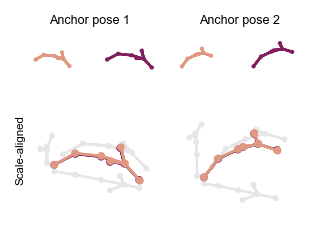

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/anchor-poses.pdf')

In [747]:
scan_align_meta = {'scale': np.array([-1. for _ in dataset.sessions])}
for src_sess, splits in split_meta[1].items():
    for s in splits:
        scan_align_meta['scale'][dataset.session_id(s)] = align_meta['scale'][dataset.session_id(src_sess)]

anchors = anchor_keypoints(
    merged_params,
    {},
    magnitudes=anchor_magnitudes(dataset_feats, merged_params, q = 0.1),
    config=cfg,
    session_meta=dataset.session_meta,
)
anchors_scale = anchor_keypoints(
    merged_params,
    align_meta,
    magnitudes=anchor_magnitudes(dataset_feats, merged_params, q = 0.1),
    config=cfg,
    session_meta=dataset.session_meta,
)


kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, shad=True: [
    plot_mouse_3d(f, a, **kws(c, sm * 14, 1.5))] + ([
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', sm * 7, 1)),
    plot_mouse_3d(dropy(f, 15), a, **kws('.9', sm * 7, 1)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', sm * 7, 1)),
] if shad else [])

gs = plt.GridSpec(2, 4, height_ratios=[1, 2])
fig = plt.figure(figsize=(2, 1.5), dpi = 150)
row0 = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(4)])
row1 = np.array([fig.add_subplot(gs[1, 2*i:2*i+2], projection='3d') for i in range(2)])

ref_sess_id = dataset.session_id(f'{ref_age}wk_m0')
ref_body = dataset.session_body_id(f'{ref_age}wk_m0')
tgt_sess_id = dataset.session_id(f'{tgt_age}wk_m0')
tgt_body = dataset.session_body_id(f'{tgt_age}wk_m0')
for a, b in zip(row0[::2], row0[1::2]):
    a.sharex(b)
    a.sharey(b)
    a.sharez(b)

plotdrop(anchors_scale[ref_sess_id, 0], row0[0], ref_color, 0.3, False)
plotdrop(anchors_scale[tgt_sess_id, 0], row0[1], tgt_color, 0.3, False)
plotdrop(anchors_scale[ref_sess_id, 1], row0[2], ref_color, 0.3, False)
plotdrop(anchors_scale[tgt_sess_id, 1], row0[3], tgt_color, 0.3, False)
plotdrop(anchors[ref_sess_id, 0], row1[0], ref_color)
plotdrop(anchors[tgt_sess_id, 0], row1[0], tgt_color)
plotdrop(anchors[ref_sess_id, 1], row1[1], ref_color)
plotdrop(anchors[tgt_sess_id, 1], row1[1], tgt_color)

fig.text(0.25, 1, 'Anchor pose 1', ha='center', va='top')
fig.text(0.75, 1, 'Anchor pose 2', ha='center', va='top')
fig.text(0.02, 0.4, "Scale-aligned", ha = 'center', va = 'center', rotation=90, size=5.5)

plotter.finalize(fig, 'anchor-poses')

#### 2. Bone length distributions

groups: {'24wk_m1': '24', '24wk_m0': '24', '24wk_m2': '24', '24wk_m3': '24', '3wk_m1': '3', '3wk_m0': '3', '24wk_m4': '24', '3wk_m2': '3', '3wk_m3': '3', '24wk_m5': '24'}


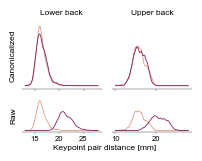

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/bl-distributions.pdf')

In [756]:
rescale = True

loback_ix = bone_names.index('hips-back') if 'hips-back' in bone_names else bone_names.index('back-hips')
hiback_ix = bone_names.index('back-shldr') if 'back-shldr' in bone_names else bone_names.index('shldr-back')
# lfpaw_ix = bone_names.index('lf_foot-shldr') if 'lf_foot-shldr' in bone_names else bone_names.index('shldr-lf_foot')
# rfpaw_ix = bone_names.index('rf_foot-shldr') if 'rf_foot-shldr' in bone_names else bone_names.index('shldr-rf_foot')

# ---- canonicalize, compute bone lengths of canonical and raw
canonicalized, raw, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to=ref_session)
bls_canon, bls_raw, _ = canonicalized_raw_bls(canonicalized, raw, dataset.sessions, parts = [''])

loback_canon = {k: v[:, loback_ix] for k, v in bls_canon.items()}
loback_raw = {k: v[:, loback_ix] for k, v in bls_raw.items()}
hiback_canon = {k: v[:, hiback_ix] for k, v in bls_canon.items()}
hiback_raw = {k: v[:, hiback_ix] for k, v in bls_raw.items()}
# flimb_canon = {k: v[:, [lfpaw_ix, rfpaw_ix]].mean(axis = 1) for k, v in bls_canon.items()}
# flimb_raw = {k: v[:, [lfpaw_ix, rfpaw_ix]].mean(axis = 1) for k, v in bls_raw.items()}


# ---- plot bone length distributions
fig, ax = plt.subplots(2, 2, figsize=(2, 1.5), sharex='col', sharey='row', height_ratios = [2, 1])
for group, color in zip([ref_age] + tgt_ages, [ref_color] + tgt_colors):

    loback_x = np.linspace(13, 28, 200)
    hiback_x = np.linspace(10, 28, 200)

    kw = dict(lw = 0.6, color = color, label = group)
    ax[0, 0].plot(*viz.util.kde(loback_canon[group], bw = 0.2, density=True, eval_x=loback_x), **kw)
    ax[0, 1].plot(*viz.util.kde(hiback_canon[group], bw = 0.2, density=True, eval_x=hiback_x), **kw)
    ax[1, 0].plot(*viz.util.kde(loback_raw[group], bw = 0.2, density=True, eval_x=loback_x), **kw)
    ax[1, 1].plot(*viz.util.kde(hiback_raw[group], bw = 0.2, density=True, eval_x=hiback_x), **kw)

for a in ax.ravel():
    a.set_yticks([])
    sns.despine(ax = a, left=True)

ax[0, 0].set_ylabel("Canonicalized")
ax[1, 0].set_ylabel("Raw")
# ax[1, 0].set_xlabel("Keypoint pair distance [mm]")
fig.text(0.52, 0.02, "Keypoint pair distance [mm]", ha='center', va='center')
ax[0, 0].set_title("Lower back")
# ax[0, 1].set_title("Forelimbs (mean)")
ax[0, 1].set_title("Upper back")

plotter.finalize(fig, 'bl-distributions', despine=False)



#### 3. IQR of mean bone lengths

(only have 3 ages at the moment, so using full range)

[('lo back', 'back-hips'), ('hi back', 'shldr-back'), ('neck', 'head-shldr'), ('l_ear', 'l_ear-head'), ('r_ear', 'r_ear-head'), ('head', 'nose-head')]
groups: {'24wk_m1': '24', '24wk_m0': '24', '24wk_m2': '24', '24wk_m3': '24', '3wk_m1': '3', '3wk_m0': '3', '24wk_m4': '24', '3wk_m2': '3', '3wk_m3': '3', '24wk_m5': '24'}


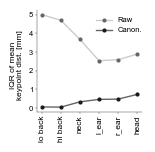

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/mean-bl-iqr.pdf')

In [867]:
rescale = True
short_names = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
print(list(zip(short_names, bone_names)))
bone_order = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']

bone_ix_order = [short_names.index(n) for n in bone_order]
bone_name_order = [short_names[i] for i in bone_ix_order]

sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to=ref_session)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = [""])
meanbls_canon = [[a[:, ix].mean() for a in bls_canon.values()] for ix in bone_ix_order]
meanbls_raw = [[a[:, ix].mean() for a in bls_raw.values()] for ix in bone_ix_order]

iqrs_canon = np.percentile(meanbls_canon, 100, axis = 1) - np.percentile(meanbls_canon, 0, axis = 1)
iqrs_raw = np.percentile(meanbls_raw, 100, axis = 1) - np.percentile(meanbls_raw, 0, axis = 1)

fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))
ax.plot(iqrs_raw, 'o-', color='.8', mfc='.4', mew=0, lw = 1, ms = 3, label='Raw')
ax.plot(iqrs_canon, 'o-', color='.4', mfc='.1', mew=0, lw = 1, ms = 3, label='Canon.')

ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels(bone_name_order, rotation = 90, fontsize = 6)
ax.set_ylabel("IQR of mean    \nkeypoint dist. [mm]    ")
viz.util.legend(ax, loc = 'upper left', frameon = False, bbox_to_anchor = (0.5, 1))

plotter.finalize(fig, 'mean-bl-iqr')



#### 4. Relative growth rates

Regression coefficient of log-age vs average bone length ratios to other bones

groups: {'24wk_m1': '24', '24wk_m0': '24', '24wk_m2': '24', '24wk_m3': '24', '3wk_m1': '3', '3wk_m0': '3', '24wk_m4': '24', '3wk_m2': '3', '3wk_m3': '3', '24wk_m5': '24'}


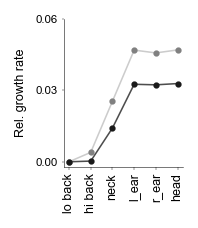

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/rel-growth-rates.pdf')

In [866]:
rescale=True
short_names = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
bone_order = ['lo back', 'hi back', 'neck', 'l_ear', 'r_ear', 'head']
group_order = [ref_age] + tgt_ages


sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to = ref_session)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = [''])


bone_ix_order = [short_names.index(n) for n in bone_order]
bone_name_order = [short_names[i] for i in bone_ix_order]

cov = lambda x, y: (x * y).mean(axis=-1) - x.mean(axis=-1) * y.mean(axis=-1)
coef = lambda a, b: cov(a, b) / cov(a, a)
coefs_raw = np.zeros([len(bone_order)] * 2)
coefs_canon = np.zeros([len(bone_order)] * 2)


for (r, r_ix), (c, c_ix) in iit.product(enumerate(bone_ix_order), enumerate(bone_ix_order)):
    if r == c:
        continue
    logage = np.log([int(g) for g in group_order])
    
    rto_canon = np.array([
        bls_canon[g][:, r_ix].mean() / bls_canon[g][:, c_ix].mean()
        for g in group_order
    ])
    coefs_canon[r, c] = coef(logage, rto_canon)

    rto_raw = np.array([
        bls_raw[g][:, r_ix].mean() / bls_raw[g][:, c_ix].mean()
        for g in group_order
    ])
    coefs_raw[r, c] = coef(logage, rto_raw)
    
fig, ax = plt.subplots(1, 1, figsize = (1.3, 1.5), dpi = 150)
ax.plot(coefs_raw[0, :], '-', color = colors.subtle, lw = 0.75, label = 'Raw')
ax.plot(coefs_raw[0, :], 'o', color = '.5', ms = 2)
ax.plot(coefs_canon[0, :], '-', color = '.3', lw = 0.75, label = 'Canon.')
ax.plot(coefs_canon[0, :], 'o', color = colors.neutral, ms = 2)

ax.set_xticks(np.arange(len(bone_order)))
ax.set_xticklabels(bone_name_order, rotation = 90, fontsize = 6)
ax.set_ylabel("Rel. growth rate")
ax.set_yticks([0, 3e-2, 6e-2])
# ax.set_ylim(-, 0.06)
plotter.finalize(fig, 'rel-growth-rates')

#### 5. framewise classification in raw and canonical pose space

In [750]:
rescale = True
sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(scan_dataset, merged_params, rescale, scale_to=ref_session)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = [''], group_bodies=False)
groups = set(re.search(r"(\d+)wk", s).group(1) for s in sessions)
groups = {k: [s for s in sessions if re.search(r"(\d+)wk", s).group(1) == k] for k in groups}

print(bls_raw.keys())
print(groups)

r_scores, r_scores_null = pairwise_group_acc(bls_raw, groups, ref_age, tgt_ages)
r_indiv_across, r_indiv_null, r_indiv_within, r_indiv_self = pairwise_framewise_acc(bls_raw, groups)
r_indiv = r_indiv_across, r_indiv_within, r_indiv_self, r_indiv_null

c_scores, c_scores_null = pairwise_group_acc(bls_canon, groups, ref_age, tgt_ages)
c_indiv_across, c_indiv_null, c_indiv_within, c_indiv_self = pairwise_framewise_acc(bls_canon, groups)
c_indiv = c_indiv_across, c_indiv_within, c_indiv_self, c_indiv_null


groups: {'24wk_m1': '24wk_m1', '24wk_m0': '24wk_m0', '24wk_m2': '24wk_m2', '24wk_m3': '24wk_m3', '3wk_m1': '3wk_m1', '3wk_m0': '3wk_m0', '24wk_m4': '24wk_m4', '3wk_m2': '3wk_m2', '3wk_m3': '3wk_m3', '24wk_m5': '24wk_m5'}
dict_keys(['3wk_m3', '3wk_m1', '24wk_m1', '24wk_m2', '24wk_m4', '24wk_m5', '24wk_m3', '3wk_m0', '24wk_m0', '3wk_m2'])
{'3': ['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'], '24': ['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '24wk_m4', '24wk_m5']}


100%|██████████| 3/3 [00:00<00:00,  6.02it/s]


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


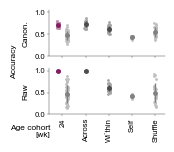

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/bl-class_pairwise.pdf')

In [751]:


strip = lambda ax, keys, data, colors, offset, **kws: viz.util.grouped_stripplot(
    viz.util.expand_groups([np.array(data[a]) for a in keys], keys),
    x=np.arange(len(keys)) + offset,
    ax=ax,
    colors=dict(zip(keys, colors)),
    points_kw=dict(ms=1),
    errorbar_kw=dict(ms=2.5),
    **{
        **dict(
            xticks="",
            lighten_points=0.5,
            offset=False,
        ),
        **kws,
    },
)

fig, ax = plt.subplots(2, 1, figsize=(1.6, 1.5), sharex=True, sharey=True)

strip(ax[1], tgt_ages, r_scores, tgt_colors, -0.2)
strip(ax[1], tgt_ages, r_scores_null, ['.5', '.5'], 0.2)
strip(ax[1], range(4), r_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))
strip(ax[0], tgt_ages, c_scores, tgt_colors, -0.2)
strip(ax[0], tgt_ages, c_scores_null, ['.5', '.5'], 0.2)
strip(ax[0], range(4), c_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))

# ax[1].set_ylim(0.0, 1.05)
# ax[1].set_yticks([0.0, 0.5, 1.0])
# ax[1].set_xticks(np.arange(len(tgt_ages) + 4))
# ax[1].set_xticklabels(tgt_ages + ["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 8)
# ax[0].set_ylabel("Accuracy\nCanon.")
# ax[1].set_ylabel("Raw")
# ax[1].set_xlabel("Age cohort [wk]")
ax[1].set_xlim(-0.6, len(tgt_ages) + 3.4)
ax[1].set_ylim(0.0, 1.05)
ax[1].set_yticks([0.0, 0.5, 1.0])
ax[1].set_xticks(np.arange(len(tgt_ages) + 4))
ax[1].set_xticklabels(tgt_ages + ["Across", "Wi`thin", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
ax[0].set_ylabel("Canon.")
ax[1].set_ylabel("Raw")
fig.text(0.23, 0.13, "Age cohort\n[wk]", ha = 'right', va = 'center', size = 6)
fig.text(0., 0.6, "Accuracy", ha='center', va='center', rotation=90)
# ax[1].set_xlabel("Age cohort [wk]")

plotter.finalize(fig, "bl-class_pairwise", despine=True, tight=True)

##### Joint angles (has only subtle effect on joint angles)

In [752]:
rescale = False
sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to=ref_session)
jas_canon, jas_raw, groups = canonicalized_and_raw_jas(canonicalized, raw, sessions, parts = [''], group_bodies=False)
groups = set(re.search(r"(\d+)wk", s).group(1) for s in sessions)
groups = {k: [s for s in sessions if re.search(r"(\d+)wk", s).group(1) == k] for k in groups}

r_scores, r_scores_null = pairwise_group_acc(jas_raw, groups, ref_age, tgt_ages)
r_indiv_across, r_indiv_null, r_indiv_within, r_indiv_self = pairwise_framewise_acc(jas_raw, groups)
r_indiv = r_indiv_across, r_indiv_within, r_indiv_self, r_indiv_null

c_scores, c_scores_null = pairwise_group_acc(jas_canon, groups, ref_age, tgt_ages)
c_indiv_across, c_indiv_null, c_indiv_within, c_indiv_self = pairwise_framewise_acc(jas_canon, groups)
c_indiv = c_indiv_across, c_indiv_within, c_indiv_self, c_indiv_null


groups: {'24wk_m1': '24wk_m1', '24wk_m0': '24wk_m0', '24wk_m2': '24wk_m2', '24wk_m3': '24wk_m3', '3wk_m1': '3wk_m1', '3wk_m0': '3wk_m0', '24wk_m4': '24wk_m4', '3wk_m2': '3wk_m2', '3wk_m3': '3wk_m3', '24wk_m5': '24wk_m5'}


100%|██████████| 3/3 [00:00<00:00,  7.70it/s]


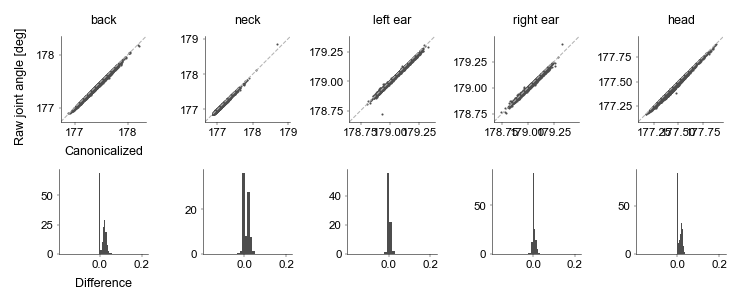

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/joint-angle-no-effect.pdf')

In [753]:
# are joint angles *exactly* the same?
fig, _, ax = viz.util.flat_grid(10, 5, ax_size = (1., 1.))
fig.set_dpi(150)
for a in ax[1, 1:]:
    a.sharex(ax[1, 0])
for i in range(5):
    for s in jas_canon:
        ax[0, i].plot(jas_canon[s][:, i], jas_raw[s][:, i], 'o', mew = 0, ms = 1, color = '.3')
    ax[0, i].set_aspect('equal')
    vmin = min(ax[0, i].get_xlim()[0], ax[0, i].get_ylim()[0])
    vmax = max(ax[0, i].get_xlim()[1], ax[0, i].get_ylim()[1])
    vmin, vmax = vmin - 0.05 * (vmax - vmin), vmax + 0.05 * (vmax - vmin)
    ax[0, i].plot([vmin, vmax], [vmin, vmax], '--', color = '.7', lw = 0.5)
    ax[0, i].set_xlim(vmin, vmax)
    ax[0, i].set_ylim(vmin, vmax)
    
    diffs = np.concatenate([jas_canon[s][:, i] - jas_raw[s][:, i] for s in jas_canon])
    ax[1, i].hist(diffs, bins = 20, color = '.3', density = True)
    ax[0, i].set_title(joint_names[i])
ax[0, 0].set_ylabel("Raw joint angle [deg]    ")
ax[0, 0].set_xlabel("Canonicalized")
ax[1, 0].set_xlabel("Difference")
plotter.finalize(fig, 'joint-angle-no-effect')


/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


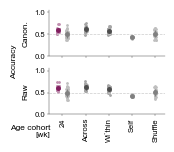

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/ja-class_pairwise.pdf')

In [754]:


strip = lambda ax, keys, data, colors, offset, **kws: viz.util.grouped_stripplot(
    viz.util.expand_groups([np.array(data[a]) for a in keys], keys),
    x=np.arange(len(keys)) + offset,
    ax=ax,
    colors=dict(zip(keys, colors)),
    points_kw=dict(ms=1),
    errorbar_kw=dict(ms=2.5),
    **{
        **dict(
            xticks="",
            lighten_points=0.5,
            offset=False,
        ),
        **kws,
    },
)

fig, ax = plt.subplots(2, 1, figsize=(1.6, 1.5), sharex=True, sharey=True)

strip(ax[1], tgt_ages, r_scores, tgt_colors, -0.2)
strip(ax[1], tgt_ages, r_scores_null, ['.5', '.5'], 0.2)
strip(ax[1], range(4), r_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))
strip(ax[0], tgt_ages, c_scores, tgt_colors, -0.2)
strip(ax[0], tgt_ages, c_scores_null, ['.5', '.5'], 0.2)
strip(ax[0], range(4), c_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))
ax[0].axhline(0.5, color = '.8', lw = 0.5, ls = '--')
ax[1].axhline(0.5, color = '.8', lw = 0.5, ls = '--')

ax[1].set_xlim(-0.6, len(tgt_ages) + 3.4)
ax[1].set_ylim(0.0, 1.05)
ax[1].set_yticks([0.0, 0.5, 1.0])
ax[1].set_xticks(np.arange(len(tgt_ages) + 4))
ax[1].set_xticklabels(tgt_ages + ["Across", "Wi`thin", "Self", "Shuffle"], rotation = 90, fontsize = 5.5)
ax[0].set_ylabel("Canon.")
ax[1].set_ylabel("Raw")
fig.text(0.23, 0.13, "Age cohort\n[wk]", ha = 'right', va = 'center', size = 6)
fig.text(0., 0.6, "Accuracy", ha='center', va='center', rotation=90)
# ax[1].set_xlabel("Age cohort [wk]")

plotter.finalize(fig, "ja-class_pairwise", despine=True, tight=True)

#### 6. Anchor pose keypoint distance to weight correlation

In [400]:
rescale = True
sessions = dataset.sessions

# ---- get rescaled raw data and anchor poses, compute paired bone length ratios

_, raw, scan_align_meta = canonicalized_and_raw(dataset_feats, merged_params, rescale=rescale, scale_to=ref_session)
anchors = anchor_keypoints(  # shape (n_session, n_anchor, n_kpt, 3)
    params.morph,
    scan_align_meta if rescale else {},
    magnitudes=anchor_magnitudes(dataset_feats, merged_params, q=0.1),
    config=cfg,
    session_meta=scan_dataset.session_meta,
)

raw_bls = {
    a: _bone_lengths(raw.get_session(f"{a}wk_m0"), arms).mean(axis = 0) 
    for a in [ref_age] + tgt_ages
}

anchor_bls = {
    a: _bone_lengths(anchors[dataset.session_id(f"{a}wk_m0")], arms)
    for a in [ref_age] + tgt_ages
}

# naive (1 GMM component) model
_, raw, scan_align_meta = canonicalized_and_raw(naive_dataset_feats, naive_merged_params, rescale=rescale, scale_to=ref_session)
anchors = anchor_keypoints(  # shape (n_session, n_anchor, n_kpt, 3)
    naive_merged_params,
    scan_align_meta if rescale else {},
    magnitudes=anchor_magnitudes(naive_dataset_feats, naive_merged_params, q=0.1),
    config=naive_cfg,
    session_meta=naive_scan_dataset.session_meta,
)

naive_raw_bls = {
    a: _bone_lengths(raw.get_session(f"{a}wk_m0"), arms).mean(axis = 0) 
    for a in [ref_age] + tgt_ages
}

naive_anchor_bls = {
    a: _bone_lengths(anchors[dataset.session_id(f"{a}wk_m0")], arms)
    for a in [ref_age] + tgt_ages
}



In [375]:
# load subject weights
subj_meta = pd.read_csv("../../../data_explore/data/meta.csv")
age_weights = {
    a: subj_meta.loc[subj_meta['Age (wk)'].astype('str') == a, 'Weight (g)'].mean()
    for a in [ref_age] + tgt_ages
}


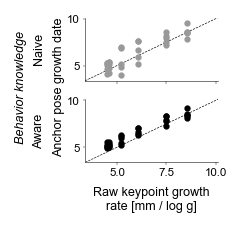

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/naive-growth-rate.pdf')

In [917]:
fig, ax = plt.subplots(2, 1, figsize = (1.5, 1.5), dpi = 150, sharex = True)

for i, (b, bi) in enumerate(zip(bone_order, bone_ix_order)):
    x = [age_weights[ref_age]] + [age_weights[t] for t in tgt_ages] 
    raw_y = [raw_bls[ref_age][bi]] + [raw_bls[t][bi] for t in tgt_ages]
    anch_y = np.stack([anchor_bls[ref_age][..., bi]] + [anchor_bls[t][..., bi] for t in tgt_ages])
    c = [ref_color] + tgt_colors
    

    cov = lambda x, y: (np.array(x) * np.array(y)).mean(axis=-1) - np.array(x).mean(axis=-1) * np.array(y).mean(axis=-1)
    coef = lambda a, b: cov(a, b) / cov(a, a)
    raw_coef = coef(np.log(x), raw_y)
    anch_coef = [coef(np.log(x), anch_y[:, k]) for k in range(naive_merged_params.n_dims + 1)]
    

    naive_raw_y = [naive_raw_bls[ref_age][bi]] + [naive_raw_bls[t][bi] for t in tgt_ages]
    naive_anch_y = np.stack([naive_anchor_bls[ref_age][..., bi]] + [naive_anchor_bls[t][..., bi] for t in tgt_ages])
    naive_raw_coef = coef(np.log(x), naive_raw_y)
    naive_anch_coef = [coef(np.log(x), naive_anch_y[:, k]) for k in range(naive_merged_params.n_dims + 1)]
    
    ax[0].plot([naive_raw_coef] * len(naive_anch_coef), naive_anch_coef, 'o', color = '.6', ms = 2)
    ax[1].plot([raw_coef] * len(anch_coef), anch_coef, 'o', color = 'k', ms = 2)

vmin, vmax = np.inf, -np.inf
for a in ax:
    vmin = min(vmin, a.get_xlim()[0], a.get_ylim()[0])
    vmax = max(vmax, a.get_xlim()[1], a.get_ylim()[1])
vmin, vmax = vmin - 0.05 * (vmax - vmin), vmax + 0.05 * (vmax - vmin)
for a in ax:
    a.plot([vmin, vmax], [vmin, vmax], 'k--', lw = 0.3, zorder = -2)
    a.set_xlim(vmin, vmax)
    a.set_ylim(vmin, vmax)
# ax.set_aspect('equal')
# ax.set_ylabel("Anchor poses coefficient")
fig.text(0.22, 0.62, "Anchor pose growth date", ha = 'center', va = 'center', rotation = 90)
fig.text(0.05, 0.62, "Behavior knowledge", ha = 'center', va = 'center', rotation = 90, fontstyle = 'italic')
ax[1].set_ylabel("Aware\n")
ax[0].set_ylabel("Naive\n")
ax[1].set_xlabel("Raw keypoint growth\nrate [mm / log g]")

plotter.finalize(fig, 'naive-growth-rate')

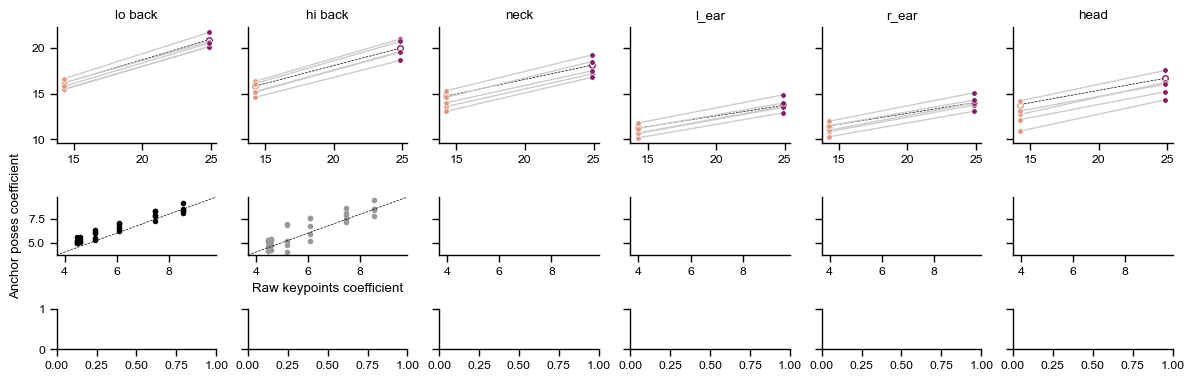

In [409]:
fig, _, ax = viz.util.flat_grid(3 * len(bone_order), len(bone_order), (2, 1.3), sharex='row', sharey='row', height_ratios=[2, 1, 0.7])
r_ax = ax[1]
naive_ax = ax[2]
ax = ax[0, ]

for i, (b, bi) in enumerate(zip(bone_order, bone_ix_order)):
    x = [age_weights[ref_age]] + [age_weights[t] for t in tgt_ages] 
    raw_y = [raw_bls[ref_age][bi]] + [raw_bls[t][bi] for t in tgt_ages]
    anch_y = np.stack([anchor_bls[ref_age][..., bi]] + [anchor_bls[t][..., bi] for t in tgt_ages])
    c = [ref_color] + tgt_colors
    ax[i].plot(x, raw_y, 'k--', lw = 0.5)
    for k in range(merged_params.n_dims + 1):
        ax[i].plot(x, anch_y[:, k], '-', color = colors.subtle, lw = 1)
    for j, a in enumerate([ref_age] + tgt_ages):
        ax[i].plot(x[j], raw_y[j], mec = c[j], mew = 1, mfc = 'w', marker = 'o', ms = 4)
        for k in range(merged_params.n_dims + 1):
            ax[i].plot(x[j], anch_y[j, k], mec = 'w', mew = 0.5, mfc = c[j], marker = 'o', ms = 4)
    ax[i].set_title(b)

    cov = lambda x, y: (np.array(x) * np.array(y)).mean(axis=-1) - np.array(x).mean(axis=-1) * np.array(y).mean(axis=-1)
    coef = lambda a, b: cov(a, b) / cov(a, a)
    raw_coef = coef(np.log(x), raw_y)
    anch_coef = [coef(np.log(x), anch_y[:, k]) for k in range(naive_merged_params.n_dims + 1)]
    r_ax[0].plot([raw_coef] * len(anch_coef), anch_coef, 'o', color = 'k', ms = 3)

    naive_raw_y = [naive_raw_bls[ref_age][bi]] + [naive_raw_bls[t][bi] for t in tgt_ages]
    naive_anch_y = np.stack([naive_anchor_bls[ref_age][..., bi]] + [naive_anchor_bls[t][..., bi] for t in tgt_ages])
    naive_raw_coef = coef(np.log(x), naive_raw_y)
    naive_anch_coef = [coef(np.log(x), naive_anch_y[:, k]) for k in range(naive_merged_params.n_dims + 1)]
    r_ax[1].plot([naive_raw_coef] * len(naive_anch_coef), naive_anch_coef, 'o', color = '.6', ms = 3)
for a in [r_ax[0], r_ax[1]]:
    vmin = min(a.get_xlim()[0], a.get_ylim()[0])
    vmax = max(a.get_xlim()[1], a.get_ylim()[1])
    a.plot([vmin, vmax], [vmin, vmax], 'k--', lw = 0.5)
    a.set_xlim(vmin, vmax)
    a.set_ylim(vmin, vmax)
    # r_ax[0].set_aspect('equal')
r_ax[0].set_ylabel("Anchor poses coefficient")
r_ax[1].set_xlabel("Raw keypoints coefficient")
    

plotter.finalize(fig, None)

#### Comparison to naive model

groups: {'24wk_m1': '24wk_m1', '24wk_m0': '24wk_m0', '24wk_m2': '24wk_m2', '24wk_m3': '24wk_m3', '3wk_m1': '3wk_m1', '3wk_m0': '3wk_m0', '24wk_m4': '24wk_m4', '3wk_m2': '3wk_m2', '3wk_m3': '3wk_m3', '24wk_m5': '24wk_m5'}
dict_keys(['3wk_m3', '3wk_m1', '24wk_m1', '24wk_m2', '24wk_m4', '24wk_m5', '24wk_m3', '3wk_m0', '24wk_m0', '3wk_m2'])
{'3': ['3wk_m1', '3wk_m0', '3wk_m2', '3wk_m3'], '24': ['24wk_m1', '24wk_m0', '24wk_m2', '24wk_m3', '24wk_m4', '24wk_m5']}


100%|██████████| 3/3 [00:00<00:00,  6.03it/s]
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kaifox/bin/miniconda3/envs/shapenorm/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


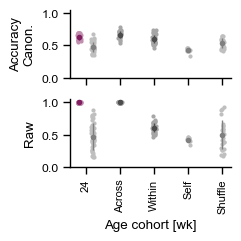

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24/models/init-scan_1/panel-plots/bl-class_pairwise.pdf')

In [383]:
rescale = True
sessions = dataset.sessions
canonicalized, raw, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to=ref_session)
bls_canon, bls_raw, groups = canonicalized_raw_bls(canonicalized, raw, sessions, parts = [''], group_bodies=False)
groups = set(re.search(r"(\d+)wk", s).group(1) for s in sessions)
groups = {k: [s for s in sessions if re.search(r"(\d+)wk", s).group(1) == k] for k in groups}

print(bls_raw.keys())
print(groups)

r_scores, r_scores_null = pairwise_group_acc(bls_raw, groups, ref_age, tgt_ages)
r_indiv_across, r_indiv_null, r_indiv_within, r_indiv_self = pairwise_framewise_acc(bls_raw, groups)
r_indiv = r_indiv_across, r_indiv_within, r_indiv_self, r_indiv_null

c_scores, c_scores_null = pairwise_group_acc(bls_canon, groups, ref_age, tgt_ages)
c_indiv_across, c_indiv_null, c_indiv_within, c_indiv_self = pairwise_framewise_acc(bls_canon, groups)
c_indiv = c_indiv_across, c_indiv_within, c_indiv_self, c_indiv_null



strip = lambda ax, keys, data, colors, offset, **kws: viz.util.grouped_stripplot(
    viz.util.expand_groups([np.array(data[a]) for a in keys], keys),
    x=np.arange(len(keys)) + offset,
    ax=ax,
    colors=dict(zip(keys, colors)),
    **{
        **dict(
            xticks="",
            lighten_points=0.5,
            offset=False,
        ),
        **kws,
    },
)

fig, ax = plt.subplots(2, 1, figsize=(2.5, 2.5), sharex=True, sharey=True)

strip(ax[1], tgt_ages, r_scores, tgt_colors, -0.2)
strip(ax[1], tgt_ages, r_scores_null, ['.5', '.5'], 0.2)
strip(ax[1], range(4), r_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))
strip(ax[0], tgt_ages, c_scores, tgt_colors, -0.2)
strip(ax[0], tgt_ages, c_scores_null, ['.5', '.5'], 0.2)
strip(ax[0], range(4), c_indiv, ['.3', '.3', '.5', '.5'], len(tgt_ages))

ax[1].set_ylim(0.0, 1.05)
ax[1].set_yticks([0.0, 0.5, 1.0])
ax[1].set_xticks(np.arange(len(tgt_ages) + 4))
ax[1].set_xticklabels(tgt_ages + ["Across", "Within", "Self", "Shuffle"], rotation = 90, fontsize = 8)
ax[0].set_ylabel("Accuracy\nCanon.")
ax[1].set_ylabel("Raw")
ax[1].set_xlabel("Age cohort [wk]")

plotter.finalize(fig, "bl-class_pairwise", save=True, despine=True, tight=True)

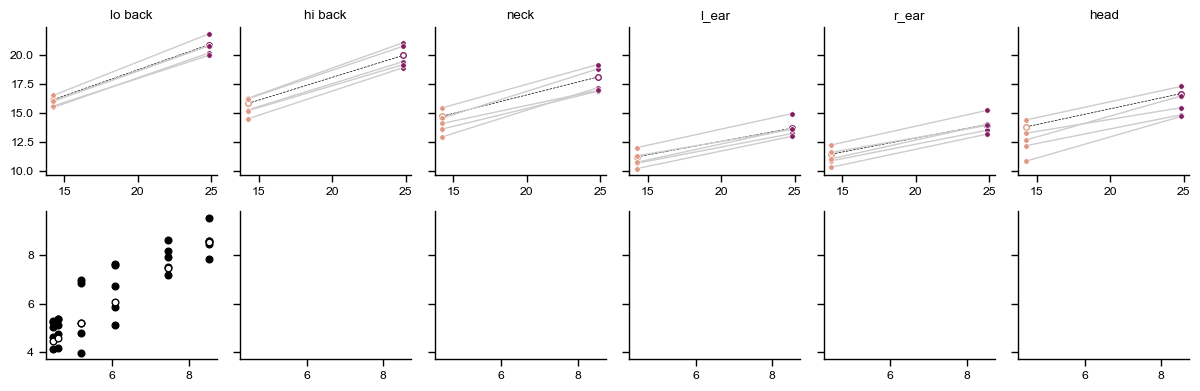

In [392]:
rescale = True
sessions = dataset.sessions

# ---- get rescaled raw data and anchor poses, compute paired bone length ratios

_, raw, scan_align_meta = canonicalized_and_raw(naive_dataset_feats, naive_merged_params, rescale=rescale, scale_to=ref_session)
anchors = anchor_keypoints(  # shape (n_session, n_anchor, n_kpt, 3)
    naive_merged_params,
    scan_align_meta if rescale else {},
    magnitudes=anchor_magnitudes(naive_dataset_feats, naive_merged_params, q=0.1),
    config=naive_cfg,
    session_meta=naive_scan_dataset.session_meta,
)

naive_raw_bls = {
    a: _bone_lengths(raw.get_session(f"{a}wk_m0"), arms).mean(axis = 0) 
    for a in [ref_age] + tgt_ages
}

naive_anchor_bls = {
    a: _bone_lengths(anchors[dataset.session_id(f"{a}wk_m0")], arms)
    for a in [ref_age] + tgt_ages
}

fig, _, ax = viz.util.flat_grid(2 * len(bone_order), len(bone_order), (2, 2), sharex='row', sharey='row',)
r_ax = ax[1]
ax = ax[0, ]

for i, (b, bi) in enumerate(zip(bone_order, bone_ix_order)):
    x = [age_weights[ref_age]] + [age_weights[t] for t in tgt_ages] 
    raw_y = [naive_raw_bls[ref_age][bi]] + [naive_raw_bls[t][bi] for t in tgt_ages]
    anch_y = np.stack([naive_anchor_bls[ref_age][..., bi]] + [naive_anchor_bls[t][..., bi] for t in tgt_ages])
    c = [ref_color] + tgt_colors
    ax[i].plot(x, raw_y, 'k--', lw = 0.5)
    for k in range(naive_merged_params.n_dims + 1):
        ax[i].plot(x, anch_y[:, k], '-', color = colors.subtle, lw = 1)
    for j, a in enumerate([ref_age] + tgt_ages):
        ax[i].plot(x[j], raw_y[j], mec = c[j], mew = 1, mfc = 'w', marker = 'o', ms = 4)
        for k in range(naive_merged_params.n_dims + 1):
            ax[i].plot(x[j], anch_y[j, k], mec = 'w', mew = 0.5, mfc = c[j], marker = 'o', ms = 4)
    ax[i].set_title(b)
    cov = lambda x, y: (np.array(x) * np.array(y)).mean(axis=-1) - np.array(x).mean(axis=-1) * np.array(y).mean(axis=-1)
    coef = lambda a, b: cov(a, b) / cov(a, a)
    raw_coef = coef(np.log(x), raw_y)
    anch_coef = [coef(np.log(x), anch_y[:, k]) for k in range(naive_merged_params.n_dims + 1)]
    r_ax[0].plot([raw_coef] * len(anch_coef), anch_coef, 'o', color = 'k')
    r_ax[0].plot([raw_coef], [raw_coef], 'o', color = 'k', mfc = 'w')
    
    

plotter.finalize(fig, None)


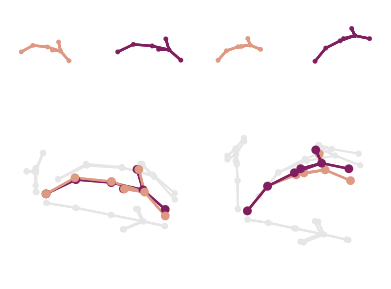

In [380]:
# naive anchor poses

scan_align_meta = {'scale': np.array([-1. for _ in naive_dataset.sessions])}
for src_sess, splits in split_meta[1].items():
    for s in splits:
        scan_align_meta['scale'][naive_dataset.session_id(s)] = align_meta['scale'][naive_dataset.session_id(src_sess)]

anchors = anchor_keypoints(
    naive_merged_params,
    {},
    magnitudes=anchor_magnitudes(naive_dataset_feats, naive_merged_params, q = 0.1),
    config=cfg,
    session_meta=naive_dataset.session_meta,
)
anchors_scale = anchor_keypoints(
    naive_merged_params,
    align_meta,
    magnitudes=anchor_magnitudes(naive_dataset_feats, naive_merged_params, q = 0.1),
    config=cfg,
    session_meta=naive_dataset.session_meta,
)


kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, shad=True: [
    plot_mouse_3d(f, a, **kws(c, sm * 40, 3))] + ([
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', sm * 20, 2)),
    plot_mouse_3d(dropy(f, 15), a, **kws('.9', sm * 20, 2)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', sm * 20, 2)),
] if shad else [])

gs = plt.GridSpec(2, 4, height_ratios=[1, 2])
fig = plt.figure(figsize=(4, 3))
row0 = np.array([fig.add_subplot(gs[0, i], projection='3d') for i in range(4)])
row1 = np.array([fig.add_subplot(gs[1, 2*i:2*i+2], projection='3d') for i in range(2)])

ref_sess_id = naive_dataset.session_id(f'{ref_age}wk_m0')
ref_body = dataset.session_body_id(f'{ref_age}wk_m0')
tgt_sess_id = dataset.session_id(f'{tgt_age}wk_m0')
tgt_body = dataset.session_body_id(f'{tgt_age}wk_m0')
for a, b in zip(row0[::2], row0[1::2]):
    a.sharex(b)
    a.sharey(b)
    a.sharez(b)

plotdrop(anchors_scale[ref_sess_id, 0], row0[0], ref_color, 0.3, False)
plotdrop(anchors_scale[tgt_sess_id, 0], row0[1], tgt_color, 0.3, False)
plotdrop(anchors_scale[ref_sess_id, 1], row0[2], ref_color, 0.3, False)
plotdrop(anchors_scale[tgt_sess_id, 1], row0[3], tgt_color, 0.3, False)
plotdrop(anchors[ref_sess_id, 0], row1[0], ref_color)
plotdrop(anchors[tgt_sess_id, 0], row1[0], tgt_color)
plotdrop(anchors[ref_sess_id, 1], row1[1], ref_color)
plotdrop(anchors[tgt_sess_id, 1], row1[1], tgt_color)

plotter.finalize(fig, None)

#### 7.1 Load supervised ethogram

In [562]:
sup_etho = jl.load('../../../data_explore/data/moont_scalar-classifier-ethograms.p')

#### 7. Supervised ethogram time

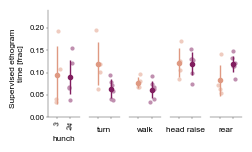

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/sup-etho-usages.pdf')

In [662]:
bhvs = sup_etho['behaviors']
bhv_names = ['hunch', 'turn', 'walk', 'head raise', 'rear']
usages = {s: sup_etho['masks'][s].mean(axis = 1) for s in dataset.sessions}
age_groups = {a: [s for s in dataset.sessions if re.search(r"(\d+)wk", s).group(1) == a] for a in [ref_age] + tgt_ages}
age_pal = dict(zip([ref_age] + tgt_ages, [ref_color] + tgt_colors))

fig, ax = plt.subplots(1, len(bhvs), figsize = (len(bhvs)*0.5, 1.5))
for i, b in enumerate(bhvs):
    for j, a in enumerate(sorted(age_groups, key = int)):
        sl = age_groups[a]
        viz.util.grouped_stripplot(
            {a: [np.array([usages[s][i] for s in sl])]},
            ax = ax[i],
            x = [j],
            colors = age_pal,
            offset=False,
            jitter = 0.2,
            lighten_points = 0.5,
        )
    ax[i].set_xticks(range(len(age_groups)))
    ax[i].set_xlabel(bhv_names[i])
    ax[i].set_xlim(-0.7, len(age_groups)-0.3)
    if i > 0:
        ax[i].set_yticks([])
        ax[i].set_xticklabels([''] * len(age_groups))
        sns.despine(ax = ax[i], left = True)
    else:
        ax[i].set_xticklabels(sorted(age_groups.keys(), key = int), rotation = 80)
        # viz.util.nticks(ax[i], 2, x = False)
        sns.despine(ax = ax[i])
ax[0].set_ylabel("Supervised ethogram    \ntime [frac]")
viz.util.round_limits(ax, 0.8, share = True, x = False, fixed_vmin = (None, 0))


plotter.finalize(fig, 'sup-etho-usages', despine = False)

#### 8. Supervised ethogram prediction

/Users/kaifox/projects/mph/generative_api/shape_norm/viz/_style.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


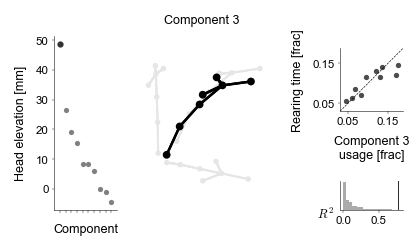

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/rearing-example.pdf')

In [864]:
head_ix = arms.keypoint_names.inverse['head']
means = features.inflate(params.pose.means, cfg['features'])
heat_ht = means[:, head_ix, 2]
head_ord = np.argsort(heat_ht)[::-1]
rear_ix = bhv_names.index('rear')
# canonicalized, _, _ = canonicalized_and_raw(dataset_feats, merged_params, rescale, scale_to=ref_session)
# canonicalized_feats = features.reduce_to_features(canonicalized, cfg['features'])
# logprobs = model.pose.pose_logprob(params.pose, canonicalized_feats)


kws = lambda c, ps, ls: dict(
    armature = arms,
    elev = 30, 
    rot = -70,
    colors = np.array([c] * arms.n_kpts),
    point_size = ps,
    line_size = ls,
    boundary=False,
)
dropz = lambda x, z: np.concatenate([x[:, :2], np.broadcast_to(z, x.shape[:-1] + (1,))], axis = -1) 
dropy = lambda x, y: np.concatenate([x[:, :1], np.broadcast_to(y, x.shape[:-1] + (1,)), x[:, 2:]], axis = -1)
dropx = lambda x, xx: np.concatenate([np.broadcast_to(xx, x.shape[:-1] + (1,)), x[:, 1:]], axis = -1)
plotdrop = lambda f, a, c, sm=1, shad=True: [
    plot_mouse_3d(f, a, **kws(c, sm * 14, 1.5))] + ([
    plot_mouse_3d(dropz(f, -5), a, **kws('.9', sm * 7, 1)),
    plot_mouse_3d(dropy(f, 15), a, **kws('.9', sm * 7, 1)),
    plot_mouse_3d(dropx(f, -5), a, **kws('.9', sm * 7, 1)),
] if shad else [])

fig = plt.figure(figsize = (3, 1.5), dpi=150)
gs = plt.GridSpec(2, 4, width_ratios = [1, 3, 1, 1], wspace=-0.1, hspace = 1, height_ratios = [3, 1])
ax = fig.add_subplot(gs[:, 0])
ax.plot([0], heat_ht[head_ord[0]], 'o', mfc = '.2', mew = 0, ms = 3.)
ax.plot(np.arange(1, params.pose.n_components), heat_ht[head_ord[1:]], 'o', mfc = '.5', mew = 0, ms = 2.5)
ax.set_xticks(np.arange(params.pose.n_components))
ax.set_xticklabels([""] * params.pose.n_components)
ax.set_ylabel("Head elevation [mm]")
ax.set_xlabel("Component")
ax.set_xlim(-1, params.pose.n_components - 1 + 1)

ax = fig.add_subplot(gs[:, 1], projection = '3d')
plotdrop(means[head_ord[0]], ax, 'k')
ax.set_title(f"Component {head_ord[0]}")



ax = fig.add_subplot(gs[0, 3])
corr_x = [
    params.pose.subj_weights[dataset.session_id(s), head_ord[0]]
    for s in dataset.sessions
]
corr_y = [
    usages[s][rear_ix]
    for s in dataset.sessions
]
ax.scatter(corr_x, corr_y, color = '.3', s = 3)
vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
vmin, vmax = vmin - 0.05 * (vmax - vmin), vmax + 0.05 * (vmax - vmin)
ax.set_xlim(vmin, vmax)
ax.set_ylim(vmin, vmax)
ax.plot([vmin, vmax], [vmin, vmax], 'k--', lw = 0.3)
ax.set_xticks([0.05, 0.15])
ax.set_yticks([0.05, 0.15])
ax.set_aspect(1.)
ax.set_xlabel(f"Component {head_ord[0]}\nusage [frac]")
ax.set_ylabel("Rearing time [frac]")

ax = fig.add_subplot(gs[1, 3])
corr = lambda x, y: np.corrcoef(x, y)[0, 1] ** 2
ax.axvline(corr(corr_x, corr_y), color = '.2', lw = 0.5)
rng = np.random.default_rng(623)
shuf = [corr(rng.permutation(corr_x), corr_y) for _ in range(1000)]
ax.hist(shuf, bins = 20, color = '.67', density = True)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.text(-0.1, 0.1, f"$R^2$", math_fontfamily = 'cm', ha = 'right', va = 'top', fontsize = 6, transform = ax.transAxes)



plotter.finalize(fig, 'rearing-example')


In [772]:
means.shape

(10, 7, 3)

In [759]:
def holdout_linear_predictions(X, Y, predictor):
    Yhat = []
    print(X.shape, Y.shape)
    for i in tqdm.trange(len(X)):
        X_train, Y_train = np.concatenate([X[:i], X[i+1:]]), np.concatenate([Y[:i], Y[i+1:]])
        X_test = X[[i]]
        predictor.fit(X_train, Y_train)
        Yhat.append(predictor.predict(X_test)[0])
    return np.array(Yhat)

In [765]:
# regression of component weights from behavior fractions
sessions = list(dataset.sessions)
X = np.array([params.pose.subj_weights[dataset.session_id(s)]for s in sessions])
Y = np.array([usages[s] for s in sessions])
Y -= Y.mean(axis = 0)
X -= X.mean(axis = 0)
Yhat = holdout_linear_predictions(X, Y, Ridge(alpha = 1e-2))
reg_errs = (Y - Yhat).T
reg_tgts = Y.T
reg_prds = Yhat.T
age_tgts = np.array([np.mean([reg_tgts[:, dataset.session_id(s)] for s in age_groups[a]], axis = 0) for a in age_groups])
age_prds = np.array([np.mean([reg_prds[:, dataset.session_id(s)] for s in age_groups[a]], axis = 0) for a in age_groups])


(10, 10) (10, 5)


100%|██████████| 10/10 [00:00<00:00, 1185.10it/s]


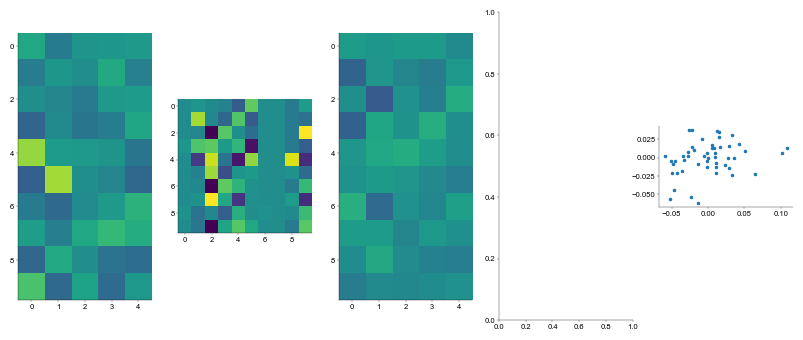

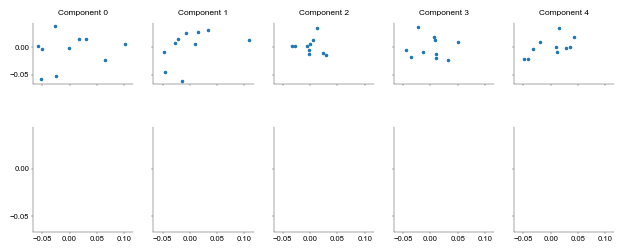

In [766]:
fig, ax = plt.subplots(1, 5, figsize = (10, 4))
ax[0].imshow(Y - Y.mean(axis = 0), vmin = -0.15, vmax = 0.15)
ax[1].imshow(X - X.mean(axis = 0))
ax[2].imshow(Yhat - Y.mean(axis = 0), vmin = -0.15, vmax = 0.15)
# ax[3].imshow(reg_errs, vmin = -0.15, vmax = 0.15)
ax[4].set_aspect('equal')
ax[4].scatter(Y.ravel(), Yhat.ravel(), s = 3)
plt.show()

fig, ax = plt.subplots(2, 5, figsize = (1.5 * 5, 3), sharex=True, sharey=True)
ax = ax.ravel()
for c in range(5):
    ax[c].scatter(Y[:, c], Yhat[:, c], s = 3)
    ax[c].set_title(f"Component {c}")
    ax[c].set_aspect('equal')
plt.show()

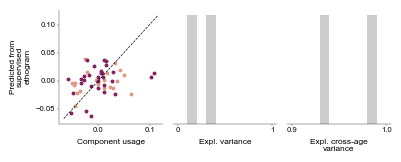

PosixPath('/Users/kaifox/projects/mph/generative_api/test/projects/ont-test/3-24-pose10/models/unif-scan_1/panel-plots/component-usage-regression.pdf')

In [767]:
# explained per-session usage variance
xpl_var = [1-np.var(reg_errs[c]) / np.var(reg_tgts[c]) for c in range(len(reg_tgts))]
# explained variance in cohort-mean usage
xage_xpl_var = [
    1 - (np.var(age_prds[:, c]) / np.var(age_tgts))
for c in range(len(reg_tgts))]

age_pal = dict(zip([ref_age] + tgt_ages, [ref_color] + tgt_colors))

fig, ax = plt.subplots(1, 3, figsize = (4, 1.6))

for a, sl in age_groups.items():
    for c in range(len(reg_tgts)):
        ax[0].scatter(
            [reg_tgts[c, dataset.session_id(s)] for s in sl],
            [reg_prds[c, dataset.session_id(s)] for s in sl],
            color = age_pal[a],
            s = 4,
        )
vmin = min(ax[0].get_xlim()[0], ax[0].get_ylim()[0])
vmax = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([vmin, vmax], [vmin, vmax], 'k--', lw = 0.5)
ax[0].set_xlabel('Component usage')
ax[0].set_ylabel("Predicted from\nsupervised\nethogram")

ax[1].hist(
    xpl_var,
    bins = np.linspace(0, 1, 11),
    color = colors.subtle,
)
ax[1].set_xticks([0, 1])
ax[1].set_xlabel("Expl. variance")

ax[2].hist(
    xage_xpl_var,
    bins = np.linspace(0.9, 1, 11),
    color = colors.subtle,
)
ax[2].set_xticks([0.9, 1])
ax[2].set_xlabel("Expl. cross-age\nvariance")

for a in ax[1:]:
    sns.despine(ax = a, left=True)
    a.set_yticks([])
sns.despine(ax = ax[0])

plotter.finalize(fig, 'component-usage-regression', despine = False)